## OCNT-DMSLIB-1 DMS Assay Run #7: TYK2 Inhibitors

| ID | Condition | Concentration (M) | Replicates
| --- | ----------- | --- | ----------- |
| 1 | None | 0 | 4 |
| 2 | IFN-alpha (100 U/mL) | 0 | 4 |
| 2 | BMS-986202 + IFN-alpha (100U/mL) | 2e-8 | 4 |
| 5 | Zasocitinib + IFN-alpha (100U/mL) | 7e-9 | 4 |
| 6 | Ropsacitinib + IFN-alpha (100U/mL) | 1e-5 | 4 |

In this framework, we have None and IFN-alpha to establish the core mutational profile of TYK2 under IFN-alpha stimulation. Then, we have each of three inhibitors (at one concentration each) co-administered with IFN-alpha.

1. [Barcode Sequencing Distributions](#part1)
2. [Inference and Stop Codon Effects](#part2)
3. [Visualizations](#part3)
4. [Drug Resistance/Gain-of-Function](#part4)
5. [Drug Potentiation](#part5)

In [2]:
library(magrittr)
library(data.table)
library(ggrepel)
library(ggpubr)
library(vroom)
library(scales)
library(scico)
library(ggridges)
library(knitr)
library(fs)
library(patchwork)
library(ggnewscale)
library(tidyverse)

scale_fill_scico_mid <- function(..., mid = 0, alpha = NULL, begin = 0, end = 1, direction = 1, reverse = TRUE ,palette = "broc") {
  if (!requireNamespace("ggplot2", quietly = TRUE)) {
        stop("ggplot2 is required for this functionality", call. = FALSE)
  }
  force(mid)
  ggplot2::continuous_scale(
    aesthetics = "fill", 
    scale_name = "gradient2",
    palette = scales::gradient_n_pal(
      colours = scico(256, alpha, begin, end, direction, palette), 
      values = NULL, space = "Lab"),
    guide="colourbar",
    rescaler = function(x, to = c(0, 1), from = range(x, na.rm = TRUE)) {
      scales::rescale_mid(x, to, from, mid)
    },
    ...
  )
}

compute_difference <- function(test, control, sumstats) {
    
    df1 <- sumstats %>% filter(condition == test) %>% select(-condition)
    df2 <- sumstats %>% filter(condition == control) %>% select(-condition)
    
    df <- inner_join(df1, df2,
                     by = c("pos", "clone", "chunk", "aa", "version", "dispersion"))
    
    new_stats <- df %>%
        mutate(estimate = estimate.x - estimate.y,
               std.error = sqrt(std.error.x^2 + std.error.y^2),
               drug = drug.x,
               conc = conc.x) %>%
        select(drug, conc, pos, clone, chunk, aa, estimate, std.error, dispersion, version) %>%
        ungroup()
    
    new_stats$condition = paste0(test, " - ", control)
    
    return(new_stats)
    
}

### Barcode Sequencing Distributions <a name="part1"></a>

In [5]:
mapped_counts <- vroom("../pipeline/OCNT-DMSLIB-1-assay-run7/tyk2-form.mapped-counts.tsv",
                          col_names = c("sample", "barcode",  "count", "lib", "chunk", 
                                        "wt_aa", "pos", "mut_aa", "wt_codon", "mut_codon",
                                        "dox", "condition", "condition_conc","clone"))  %>%
    mutate(mut_aa = if_else(mut_aa %in% c("*", "X"), "*", mut_aa),
           condition = as.factor(paste0(condition, condition_conc)),
           mut_aa = if_else(wt_aa == mut_aa | is.na(mut_aa), "WT", mut_aa),
           mut_aa = relevel(as.factor(mut_aa), ref = "WT"))

bc_counts_aa <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_aa,mut_aa,pos) %>%
    count()

bc_counts_codon <- mapped_counts %>%
    filter(mut_aa != "WT") %>%
    group_by(sample,wt_codon,mut_codon,pos) %>%
    count()

res_count <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts")

codon_count <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = n)) +
        theme_pubr() +
        geom_hline(yintercept = 30, color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts")

res_count_log <- bc_counts_aa %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red") +
        ylab("number of unique barcodes") + ggtitle("AA-level unique barcode counts, log10")

codon_count_log <- bc_counts_codon %>%
    ggplot() +
        geom_boxplot(aes(x = sample, y = log10(n))) +
        theme_pubr() +
        geom_hline(yintercept = log10(30), color = "red")  +
        ylab("number of unique barcodes") + ggtitle("Codon-level unique barcode counts, log10")

Rows: 15012426 Columns: 15
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (11): sample, barcode, lib, chunk, wt_aa, mut_aa, wt_codon, mut_codon, d...
dbl  (4): count, pos, condition, clone

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
bc_counts_aa %>% group_by(sample) %>% summarize(n = median(n)) %>% summarize(min(n), max(n), median(n))

min(n) max(n) median(n)
1 21     27     25

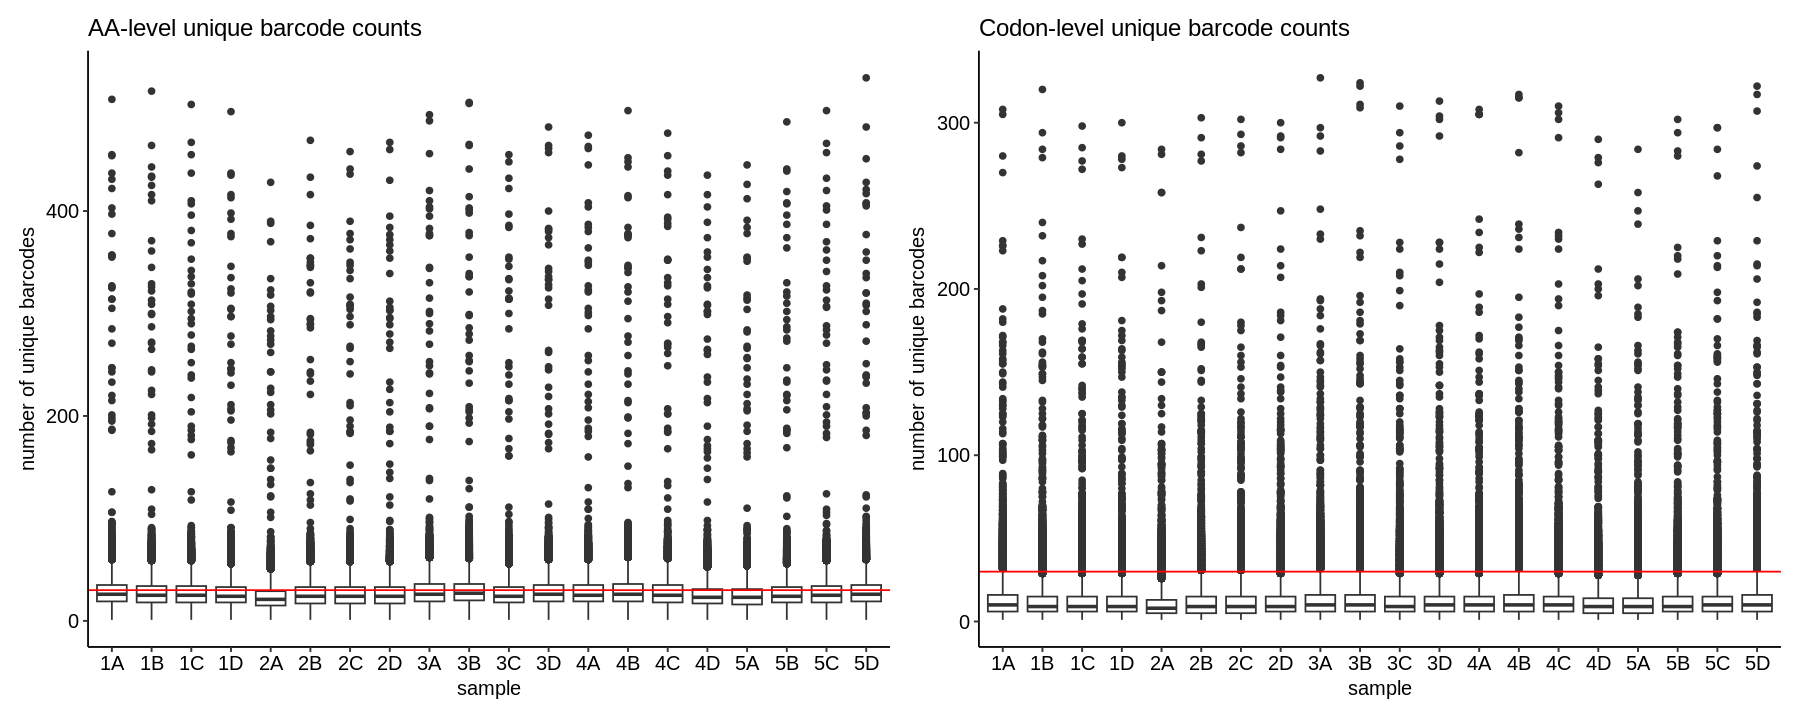

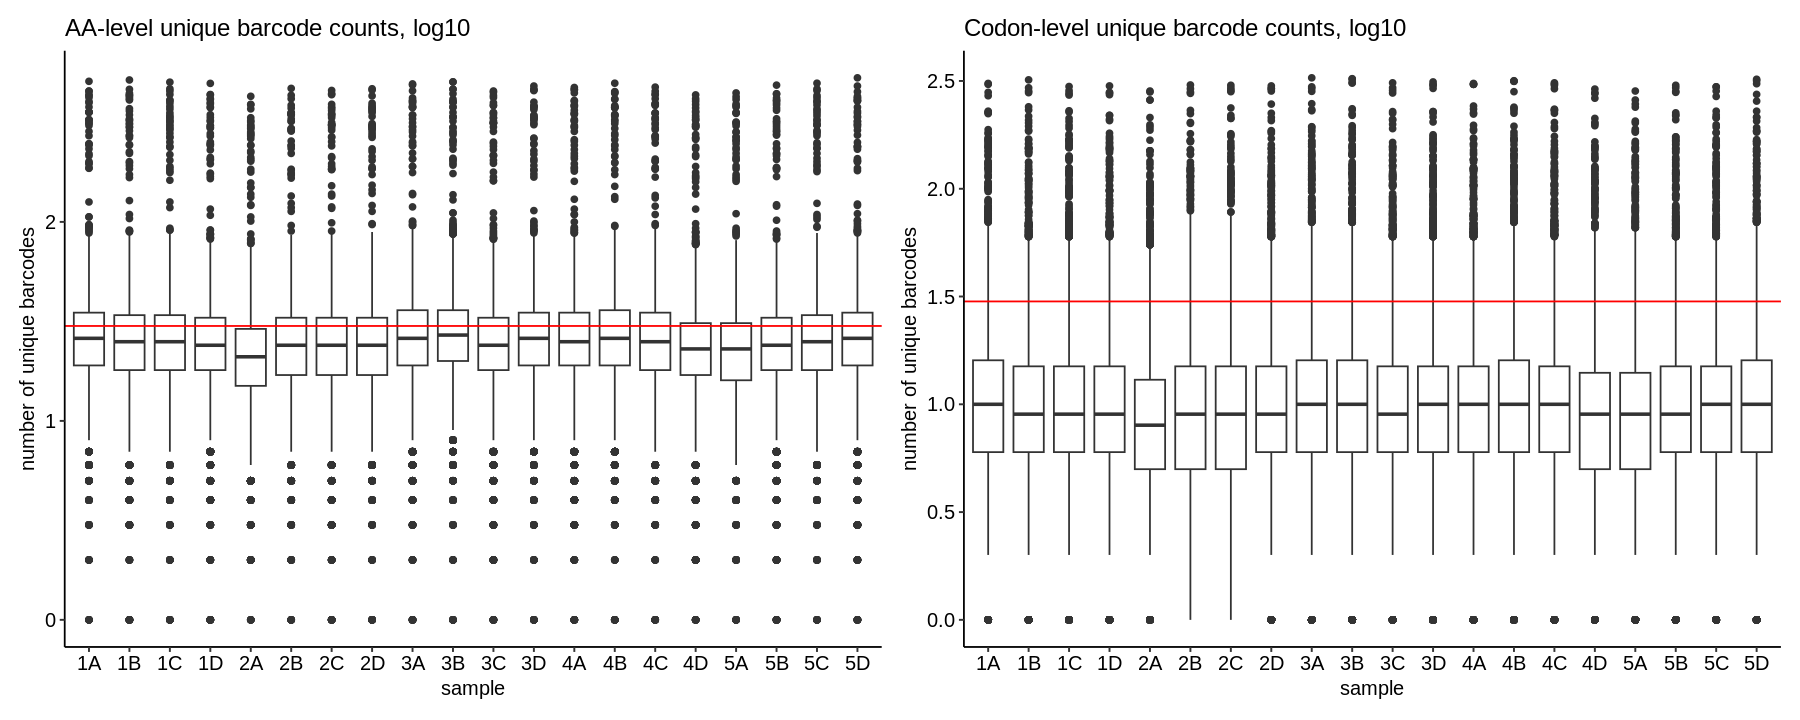

In [4]:
options(repr.plot.width = 15, repr.plot.height = 6)
res_count + codon_count
res_count_log + codon_count_log 

To get a sense of positional distribution, we can show the same data as lineplots across the length of TYK2. Below is an example using sample `1A` only; the remaining plots can be found [here](./coverage-plots):

In [5]:
plot_coverage <- function(bcs, sample_id) {
    
    wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")
    
    bcs_subset <- bcs %>%
        filter(sample == sample_id)
    
    allpos <- expand_grid("pos" = unique(bcs$pos),
                     "mut_aa" = unique(bcs$mut_aa)) %>%
        filter(!paste0(pos, mut_aa) %in% paste0(wt_aa$pos, wt_aa$wt_aa))

    bcs_subset_expanded <- allpos %>%
        left_join(bcs_subset) %>%
        mutate(n = ifelse(is.na(n), 0, n))
    
    the_plot <- ggplot(bcs_subset_expanded) +
        geom_line(aes(x = as.numeric(pos), y = log10(n))) +
        theme_bw(base_size = 16) +
        ggtitle(paste0("Sample ", sample_id)) +
        facet_wrap(~mut_aa, ncol = 1) +
        xlab("TYK2 position") + ylab("log10(number of unique barcodes)")
    
    ggsave(paste0("coverage-plots/OCNT-DMSLIB-1-assay-run7-sample", sample_id, ".pdf"),
           the_plot, width = 10, height = 20)
    
    return(the_plot)
}

In [6]:
coverage_plots <- map(.x = unique(bc_counts_aa$sample), .f = ~plot_coverage(bc_counts_aa, .))

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(pos, mut_aa)`
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(pos, mut_aa)`
Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with

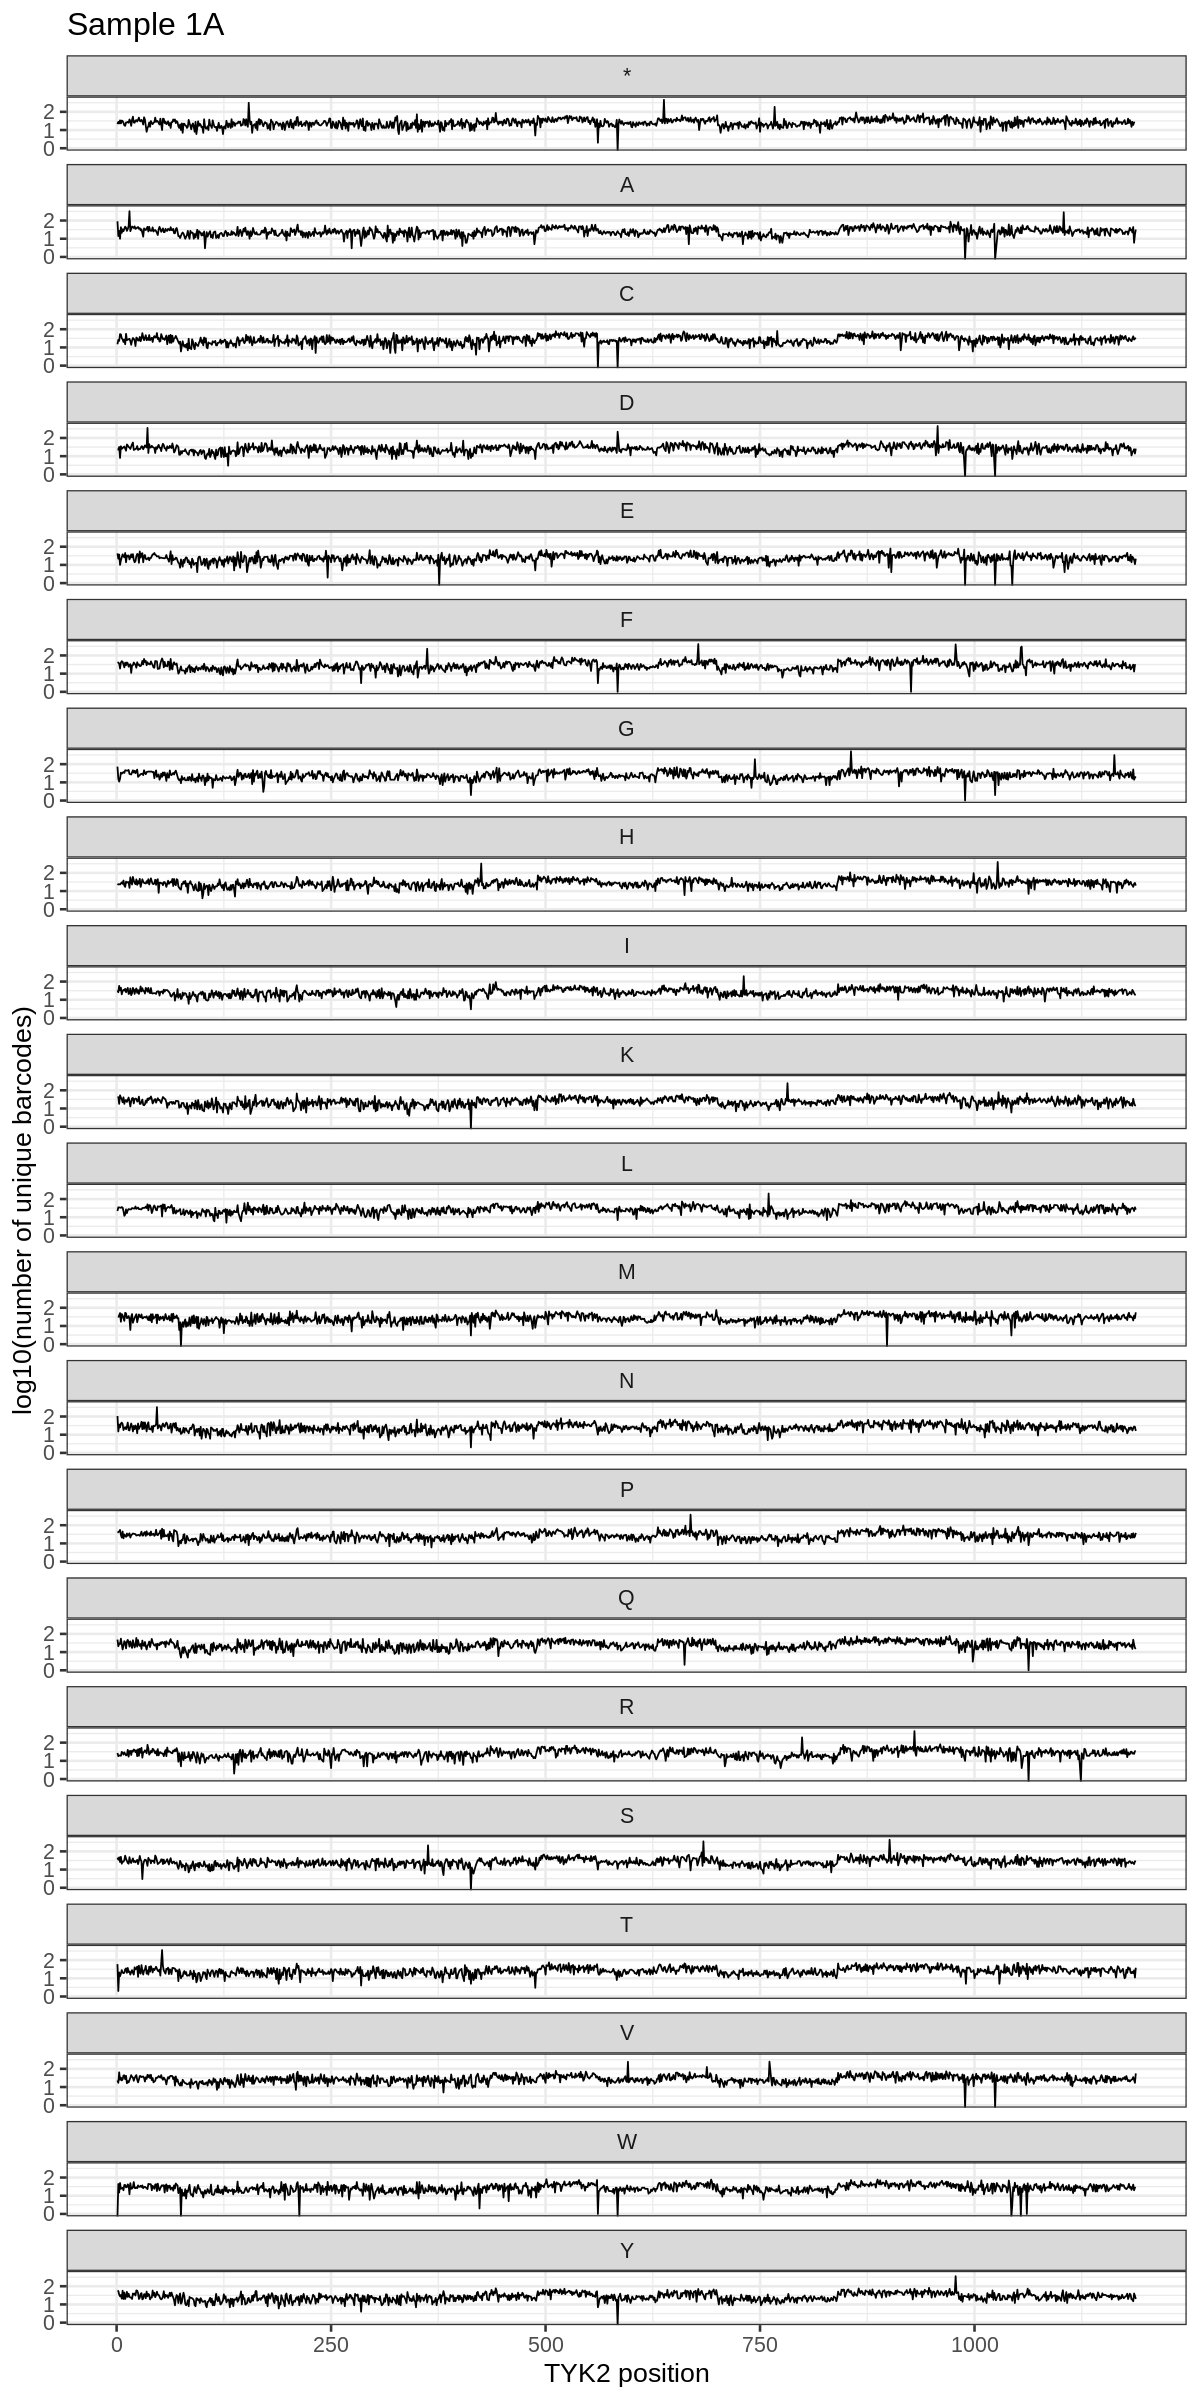

In [11]:
options(repr.plot.width = 10, repr.plot.height = 20)
coverage_plots[[1]]

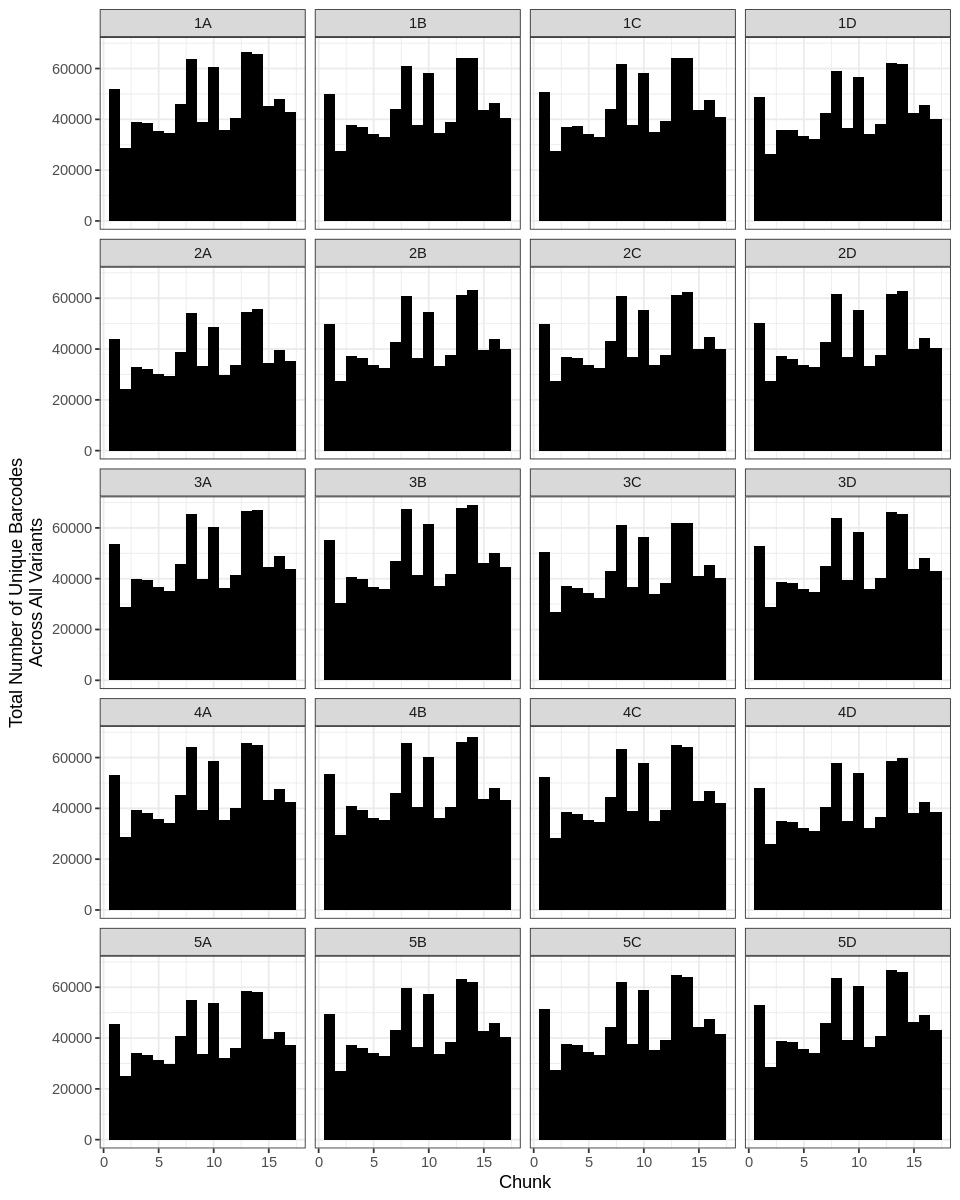

In [8]:
options(repr.plot.width = 8, repr.plot.height = 10)
mapped_counts %>%
    ungroup() %>%
    count(sample, chunk) %>%
    mutate(chunk = if_else(chunk == "12rc", "12", chunk),
           chunk = as.numeric(chunk)) %>%
    ggplot() +
        geom_bar(aes(x = chunk, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw() +
        facet_wrap(~sample, ncol = 4) +
        xlab("Chunk") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

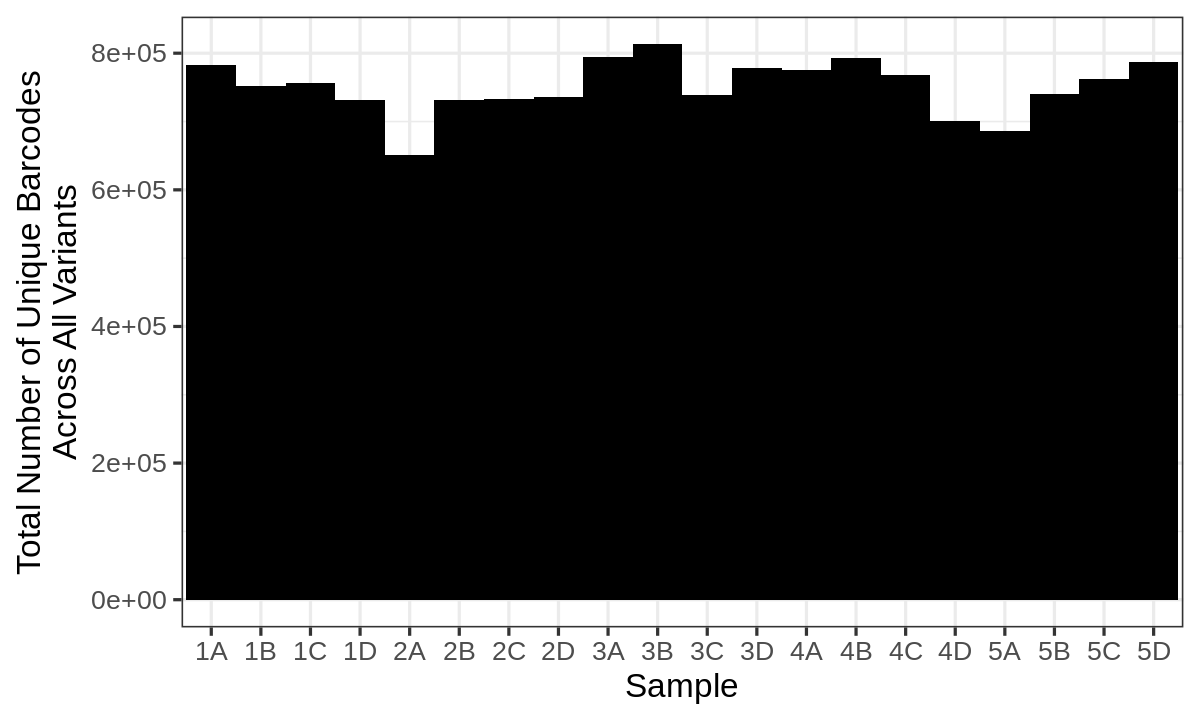

In [9]:
options(repr.plot.width = 10, repr.plot.height = 6)
mapped_counts %>%
    ungroup() %>%
    count(sample) %>%
    ggplot() +
        geom_bar(aes(x = sample, y = n), width = 1, color = NA, fill = "black", stat = "identity") +
        theme_bw(base_size = 20) +
        xlab("Sample") + ylab("Total Number of Unique Barcodes\nAcross All Variants")

### Inference and Stop Codon Effects <a name="part2"></a>

Under strong inhibition, we expect to see no difference between mutants and WT most (but not all!) of the time, since the inhibitor will suppress the activity of most mutants as it does WT. In this dataset, we have both high and low doses of inhibitors, so we can plot the distribution of stop codon effects versus all other mutations in the library (all relative to WT) and compare. In the below plot, the Non-Stop distribution in each condition is shown in black, and the Stop distribution for each chunk individually (so 17 per condition) are shown in red:

In [3]:
conditions = tibble("condition" = c("IFNalpha100+BMS-9862022e-08",
                                    "IFNalpha100+Ropsacitinib1e-05",
                                    "IFNalpha100+Zasocitinib7e-09",
                                    "IFNalpha1000",
                                    "None0"),
                    "drug" = c("IFNalpha100+BMS-986202",
                               "IFNalpha100+Ropsacitinib",
                               "IFNalpha100+Zasocitinib",
                               "IFNalpha100", "None"),
                    "conc" = c(2e-8, 1e-5, 7e-9, 0, 0))

In [5]:
sumstats <- dir_ls(path = "../sumstats/TYK2/run7/", regexp = "tyk2_.*combined.sumstats.tsv") %>%
    map_dfr(read_tsv, col_types = c("ncccnnnnnc")) %>%
    filter(grepl("aa",term), pos != 1188) %>%
    separate(term, c("condition", "aa"), ":") %>%
    mutate(estimate = estimate / log(2),
           std.error = std.error / log(2),
           condition = gsub("condition", "", condition),
           group = if_else(aa %in% c("mut_aa*", "mut_aaX"), chunk, "Non-Stop"),
           aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*","X"), "*", aa)) %>%
    left_join(conditions, by = "condition") %>%
    mutate(condition = str_c(drug, "_", conc))

wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
sumstats %>%
    mutate(p.adj = p.adjust(p.value, method = "BH")) %>%
    select(-group) %>%
    write_tsv("../sumstats/TYK2/run7/tyk2-assay7-unnormalized.tsv")

aa_uniq <- unique(sumstats$aa)
pos_uniq <- 1:1187

In [7]:
conditions <- unique(sumstats$condition)
noneIdx <- which(conditions == "None_0")

sumstats_none_contr <- map_dfr(conditions[-noneIdx],
                         ~compute_difference(test = .,
                                            control = "None_0",
                                            sumstats = sumstats)) %>%
    mutate(condition = factor(condition,
                              levels = c("IFNalpha100_0 - None_0",
                                         "IFNalpha100+BMS-986202_2e-08 - None_0",
                                         "IFNalpha100+Ropsacitinib_1e-05 - None_0",
                                         "IFNalpha100+Zasocitinib_7e-09 - None_0")))

sumstats_all <- sumstats_none_contr %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH"))


sumstats_all %>% write_tsv("../sumstats/TYK2/run7/tyk2-assay7.tsv")

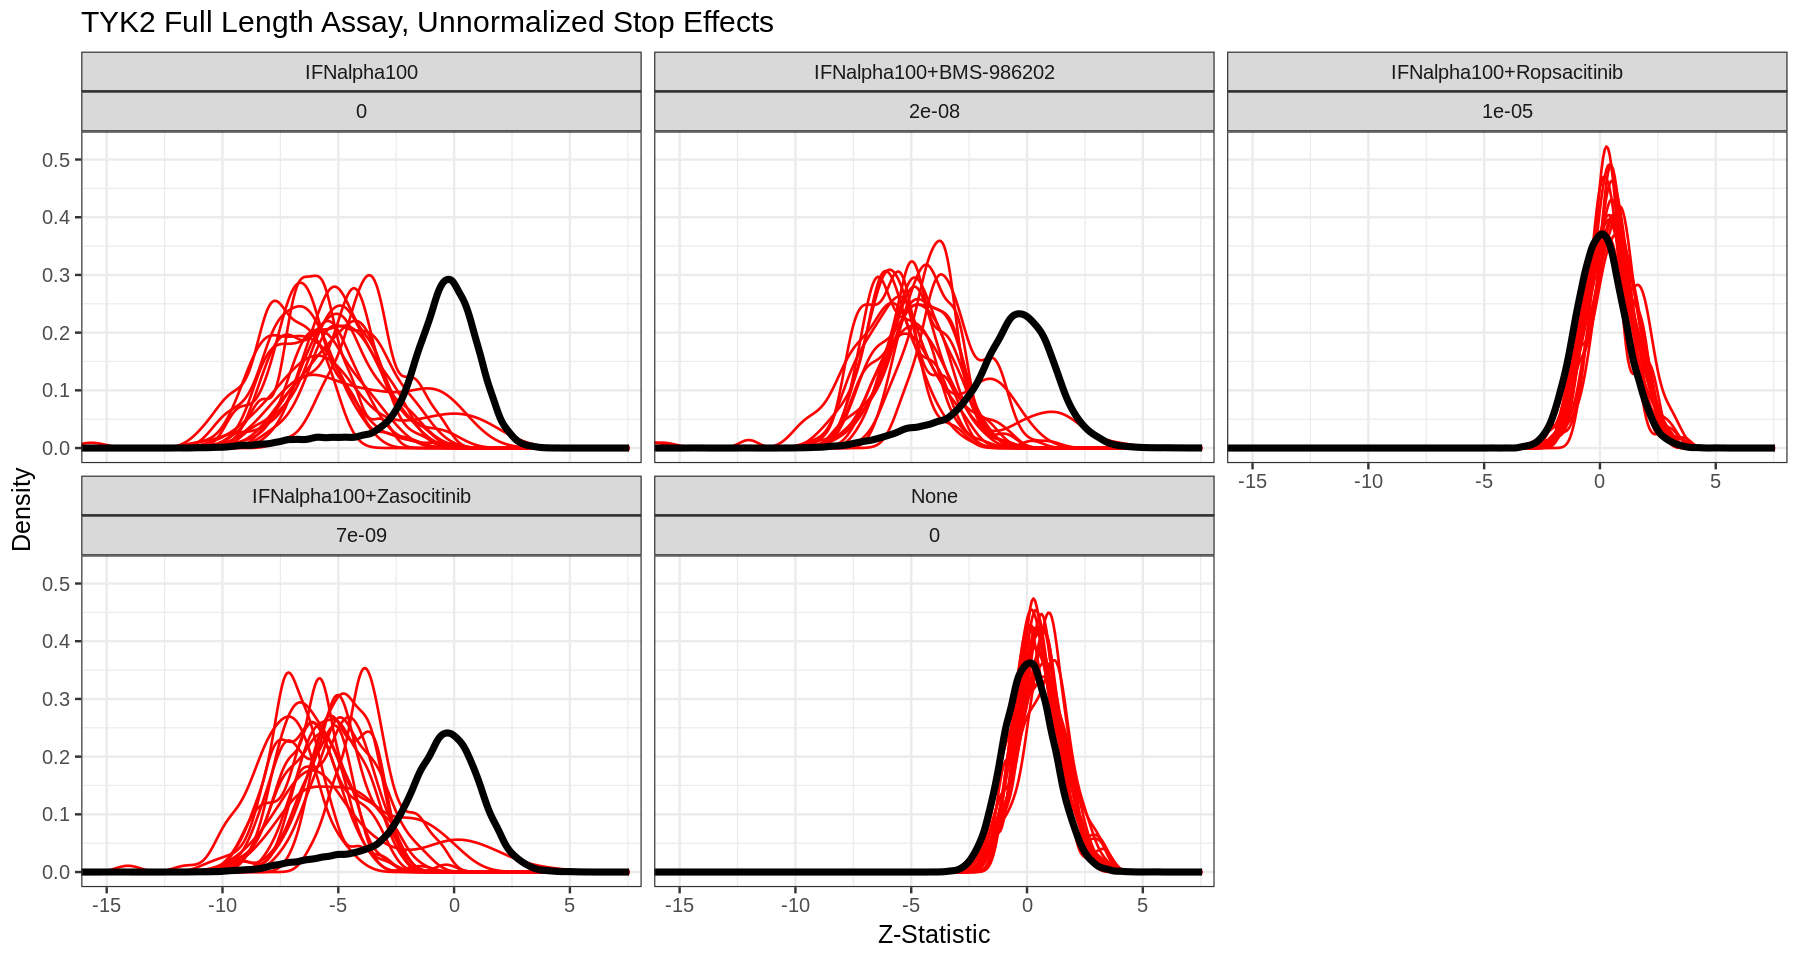

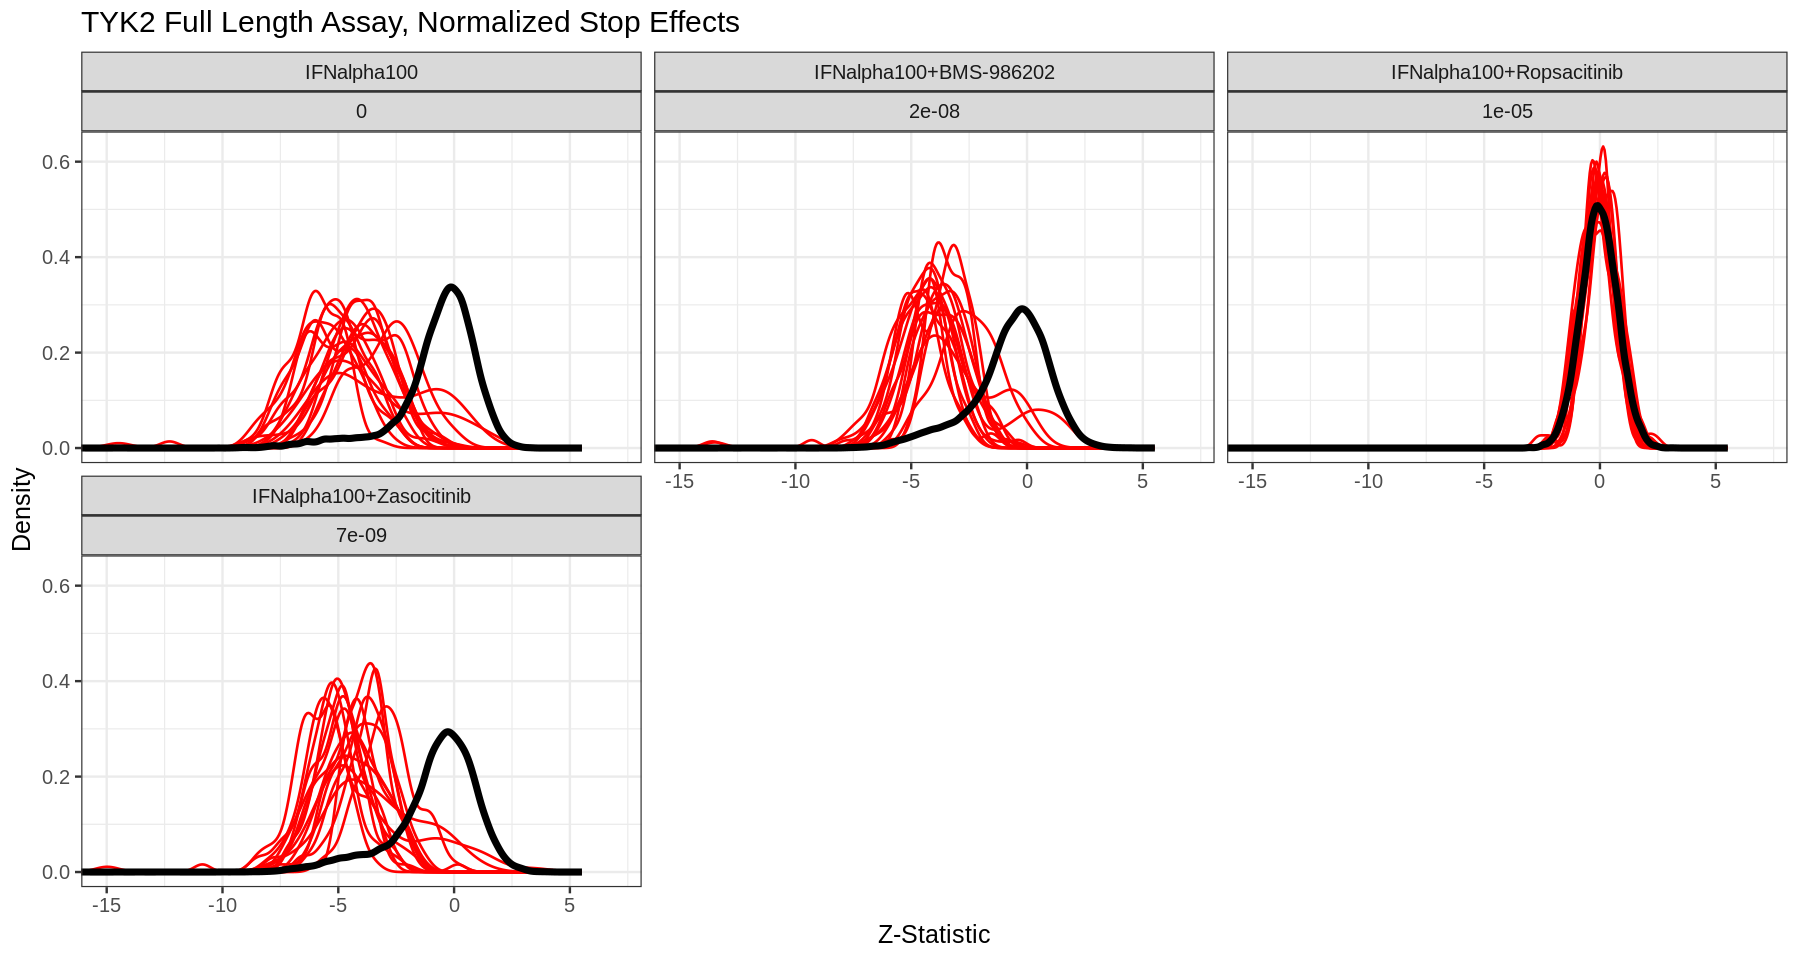

In [16]:
options(repr.plot.width = 15, repr.plot.height = 8)
sumstats %>%
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>% 
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        facet_wrap(~drug + conc, ncol = 3) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("TYK2 Full Length Assay, Unnormalized Stop Effects") +
        coord_cartesian(xlim = c(-15,7))

sumstats_all %>%
    mutate(group = if_else(aa == "*", chunk, "Non-Stop")) %>%
    ggplot() +
        geom_density(aes(x = statistic, group = group,
                         color = group != "Non-Stop",
                         size = group != "Non-Stop"), alpha = 0.5) +
        facet_wrap(~drug + conc, ncol = 3) +
        theme_bw(base_size = 15) +
        scale_color_manual(values = c("FALSE" = "black", "TRUE" = "red")) +
        scale_size_manual(values = c("FALSE" = 2, "TRUE" = 0.75)) +
        theme(legend.pos = "none") +
        xlab("Z-Statistic") + ylab("Density") +
        ggtitle("TYK2 Full Length Assay, Normalized Stop Effects") +
        coord_cartesian(xlim = c(-15,7))

We can also examine directly the number of variants across all comparisons that are significant at a 1% FDR:

In [17]:
sumstats_all %>%
    count(drug,
          conc,
          direction = if_else(estimate > 0, "GoF", "LoF"),
          sig = if_else(p.adj < 0.01, "Significant (FDR < 0.01)", "Non-Significant")) %>%
    pivot_wider(names_from = sig, values_from = n, values_fill = 0) %>%
    arrange(drug, conc) %>%
    kable(type = "markdown", digits = 10)



|drug                     |  conc|direction | Non-Significant| Significant (FDR < 0.01)|
|:------------------------|-----:|:---------|---------------:|------------------------:|
|IFNalpha100              | 0e+00|GoF       |            8651|                        1|
|IFNalpha100              | 0e+00|LoF       |           12523|                     2544|
|IFNalpha100+BMS-986202   | 2e-08|GoF       |            8154|                       33|
|IFNalpha100+BMS-986202   | 2e-08|LoF       |           12813|                     2719|
|IFNalpha100+Ropsacitinib | 1e-05|GoF       |           11478|                        0|
|IFNalpha100+Ropsacitinib | 1e-05|LoF       |           12241|                        0|
|IFNalpha100+Zasocitinib  | 7e-09|GoF       |            8133|                       17|
|IFNalpha100+Zasocitinib  | 7e-09|LoF       |           12518|                     3051|

### Visualizations <a name="part3"></a>

In [145]:
wt_aa <- read_tsv("../data/tyk2/tyk2-wt-aa.tsv")

sumstats_clin <- read_tsv("../sumstats/TYK2/run7/tyk2-assay7.tsv") %>%
    filter(condition == "IFNalpha100_0 - None_0") %>%
    left_join(wt_aa, by = "pos") %>%
    mutate( aa = gsub("mut_aa", "", aa),
            aa = if_else(aa == "*", "Stop", aa),
            mut_id = paste0(wt_aa, pos, aa))

spikeins <- read_tsv("../data/tyk2/tyk2-spikeins.tsv",
                     col_names = c("pos", "mut_id", "class")) %>%
    mutate(class = if_else(class == "-", "Unknown", class),
           class = factor(class, levels = c("LOF", "Unknown", "GOF"))) %>%
    inner_join(sumstats_clin, by = c("mut_id", "pos")) %>%
    arrange(class, pos)

spikeins$mut_id <- factor(spikeins$mut_id, levels  = spikeins$mut_id)

Rows: 1189 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): wt_aa
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 94876 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): drug, clone, chunk, aa, version, condition
dbl (8): conc, pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 32 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): mut_id, class
dbl (1): pos

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to qui

In [173]:
fiducial_plot <- ggplot(spikeins) +
    geom_pointrange(aes(x = fct_rev(mut_id) , y = estimate,
                        ymin = estimate - 2*std.error,
                        ymax = estimate + 2*std.error,
                        color = if_else(p.adj < 0.01, "magenta", "black"))) +
    theme_pubr(base_size = 13) +
    coord_flip() +
    geom_hline(yintercept = 0) +
    xlab("") + ylab("log2FoldChange +/- 2 Standard Errors") +
    scale_color_identity() +
    ylim(c(-2.5, 1)) +
    annotate("rect",
             ymin = -Inf, ymax = Inf, xmin = 0, xmax = 6.5,
             alpha = .2, fill = "goldenrod") +
    annotate("rect",
             ymin = -Inf, ymax = Inf, xmin = 17.5, xmax = 33,
             alpha = .2, fill = "blue")

ggsave("../dataviz/TYK2/ifna/TYK2-IFNaDMS-Assay7-Fiducial.pdf",
       clinvar_plot,
       width = 5,
       height = 7)

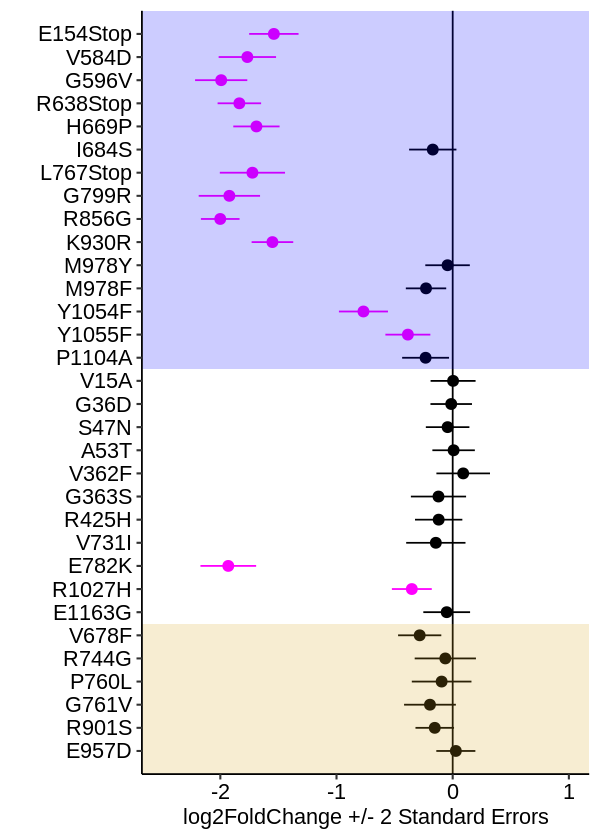

In [174]:
options(repr.plot.width = 5, repr.plot.height = 7)
fiducial_plot

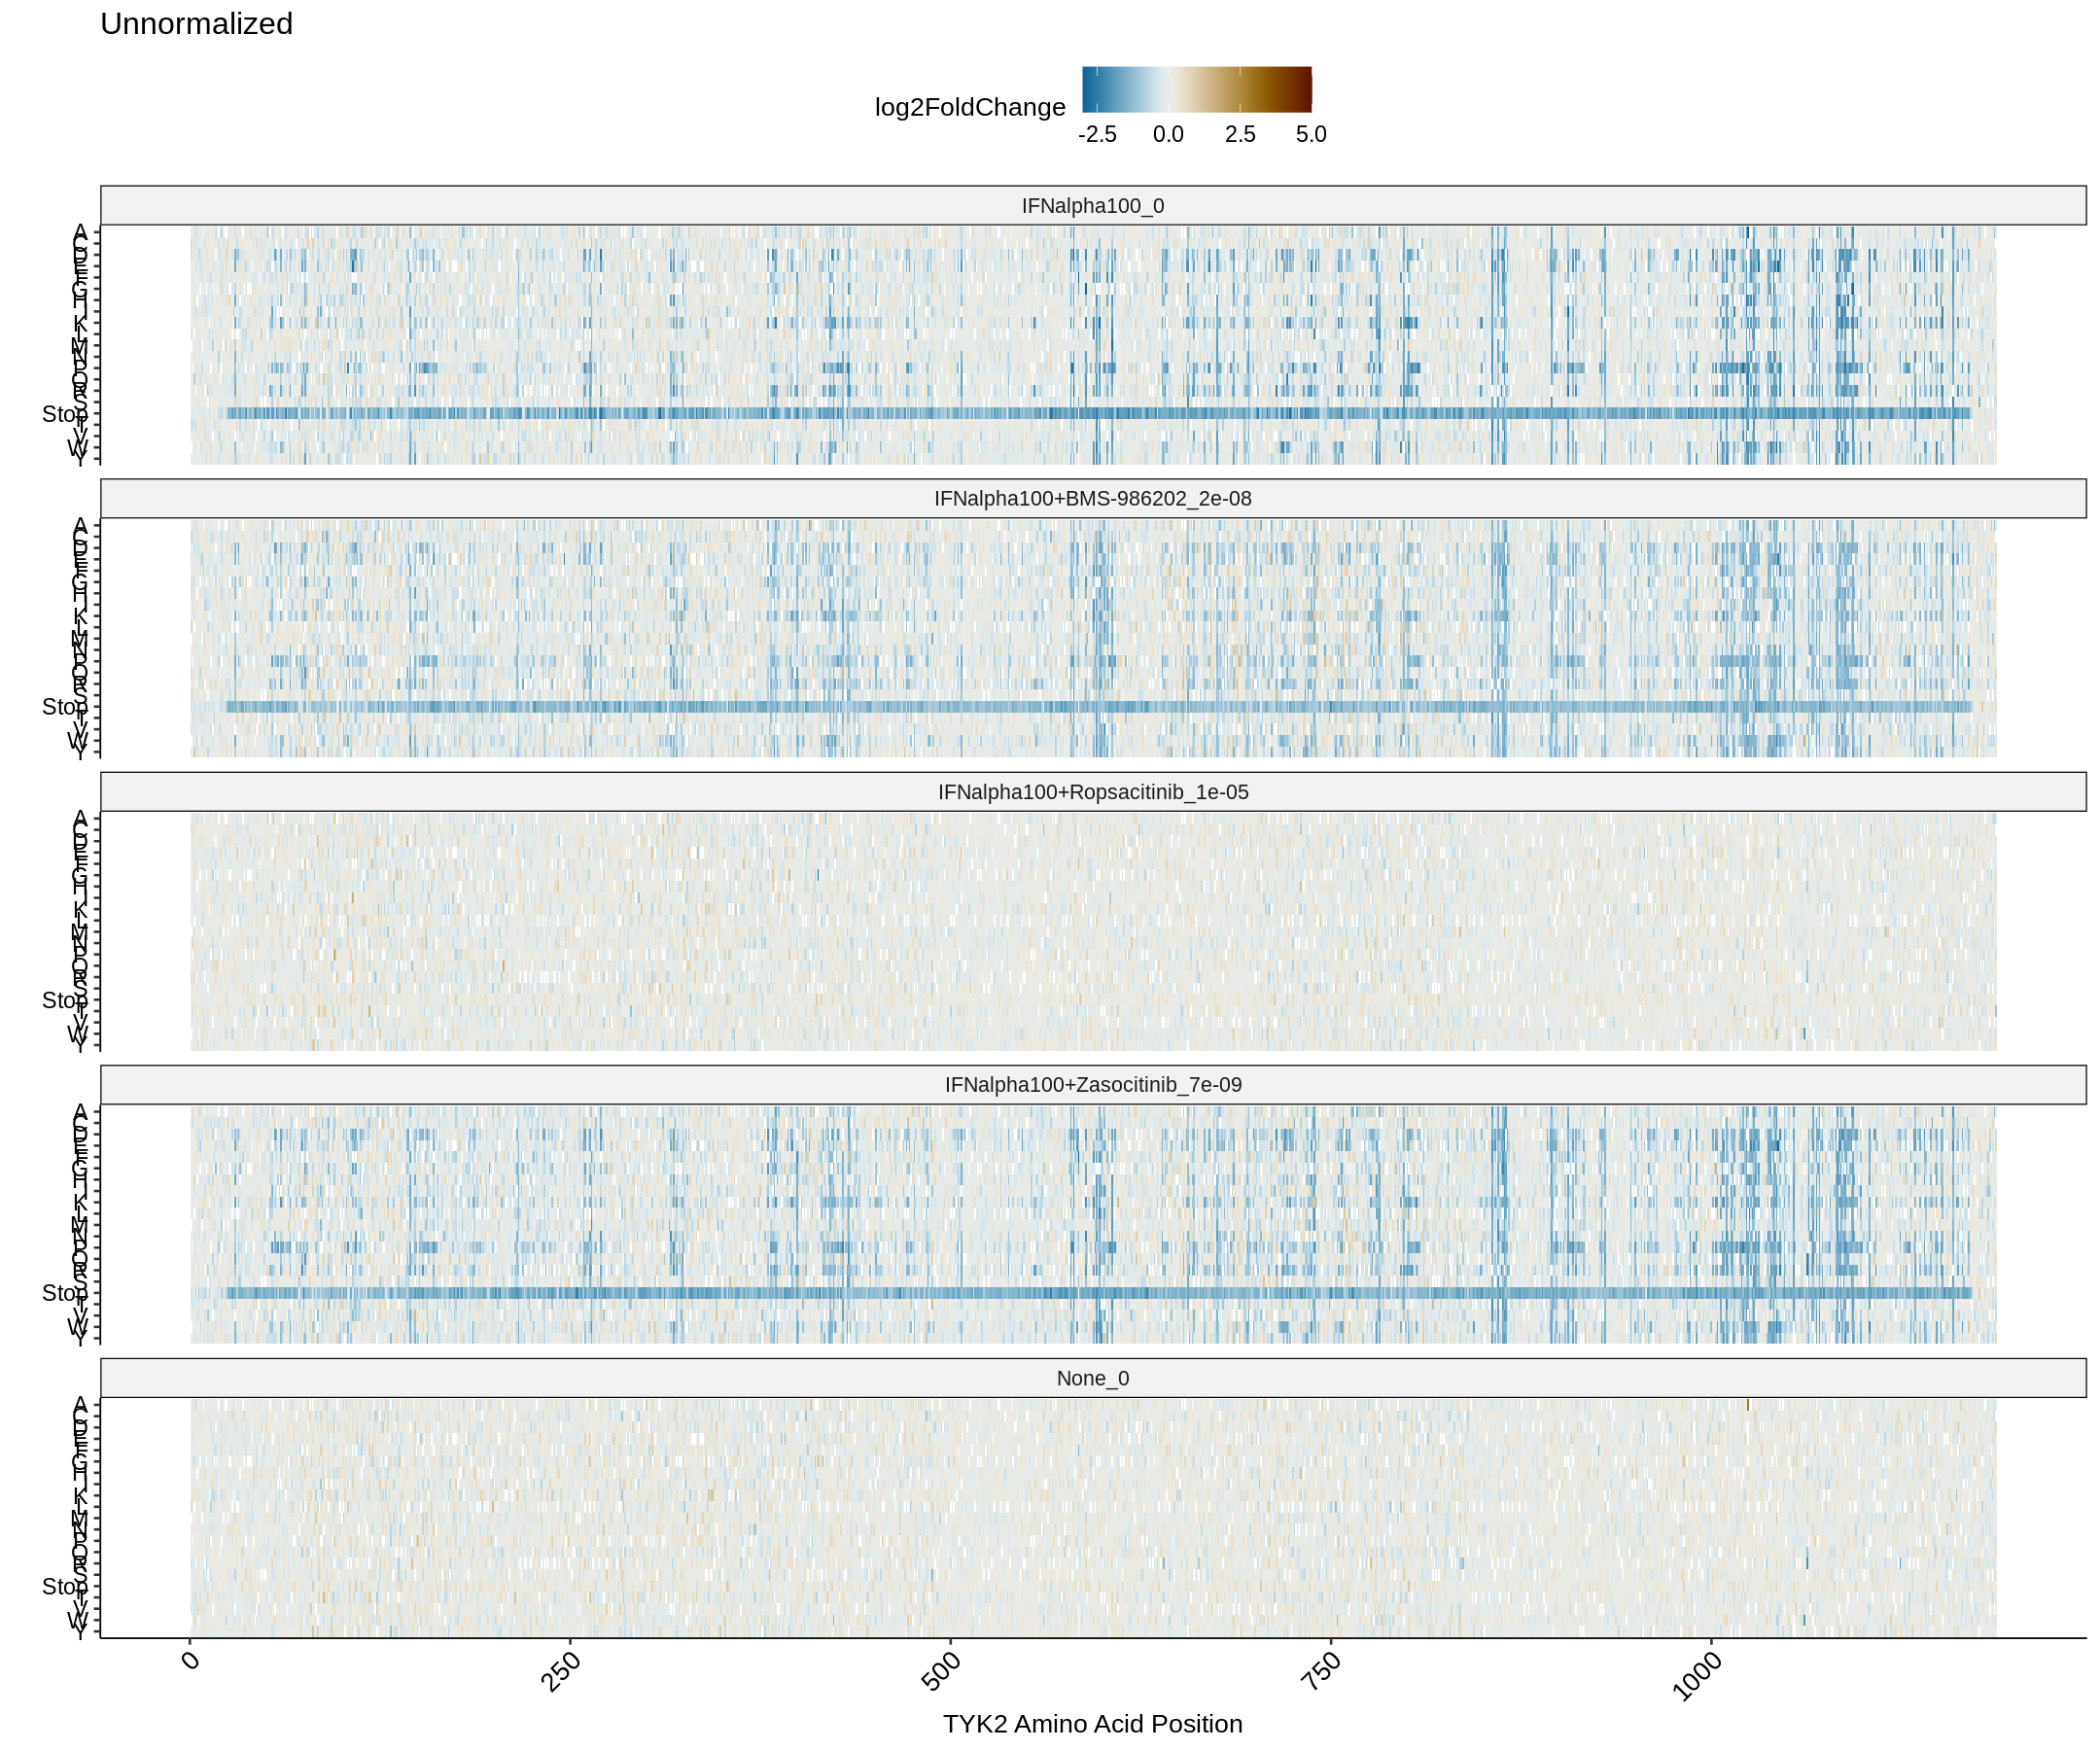

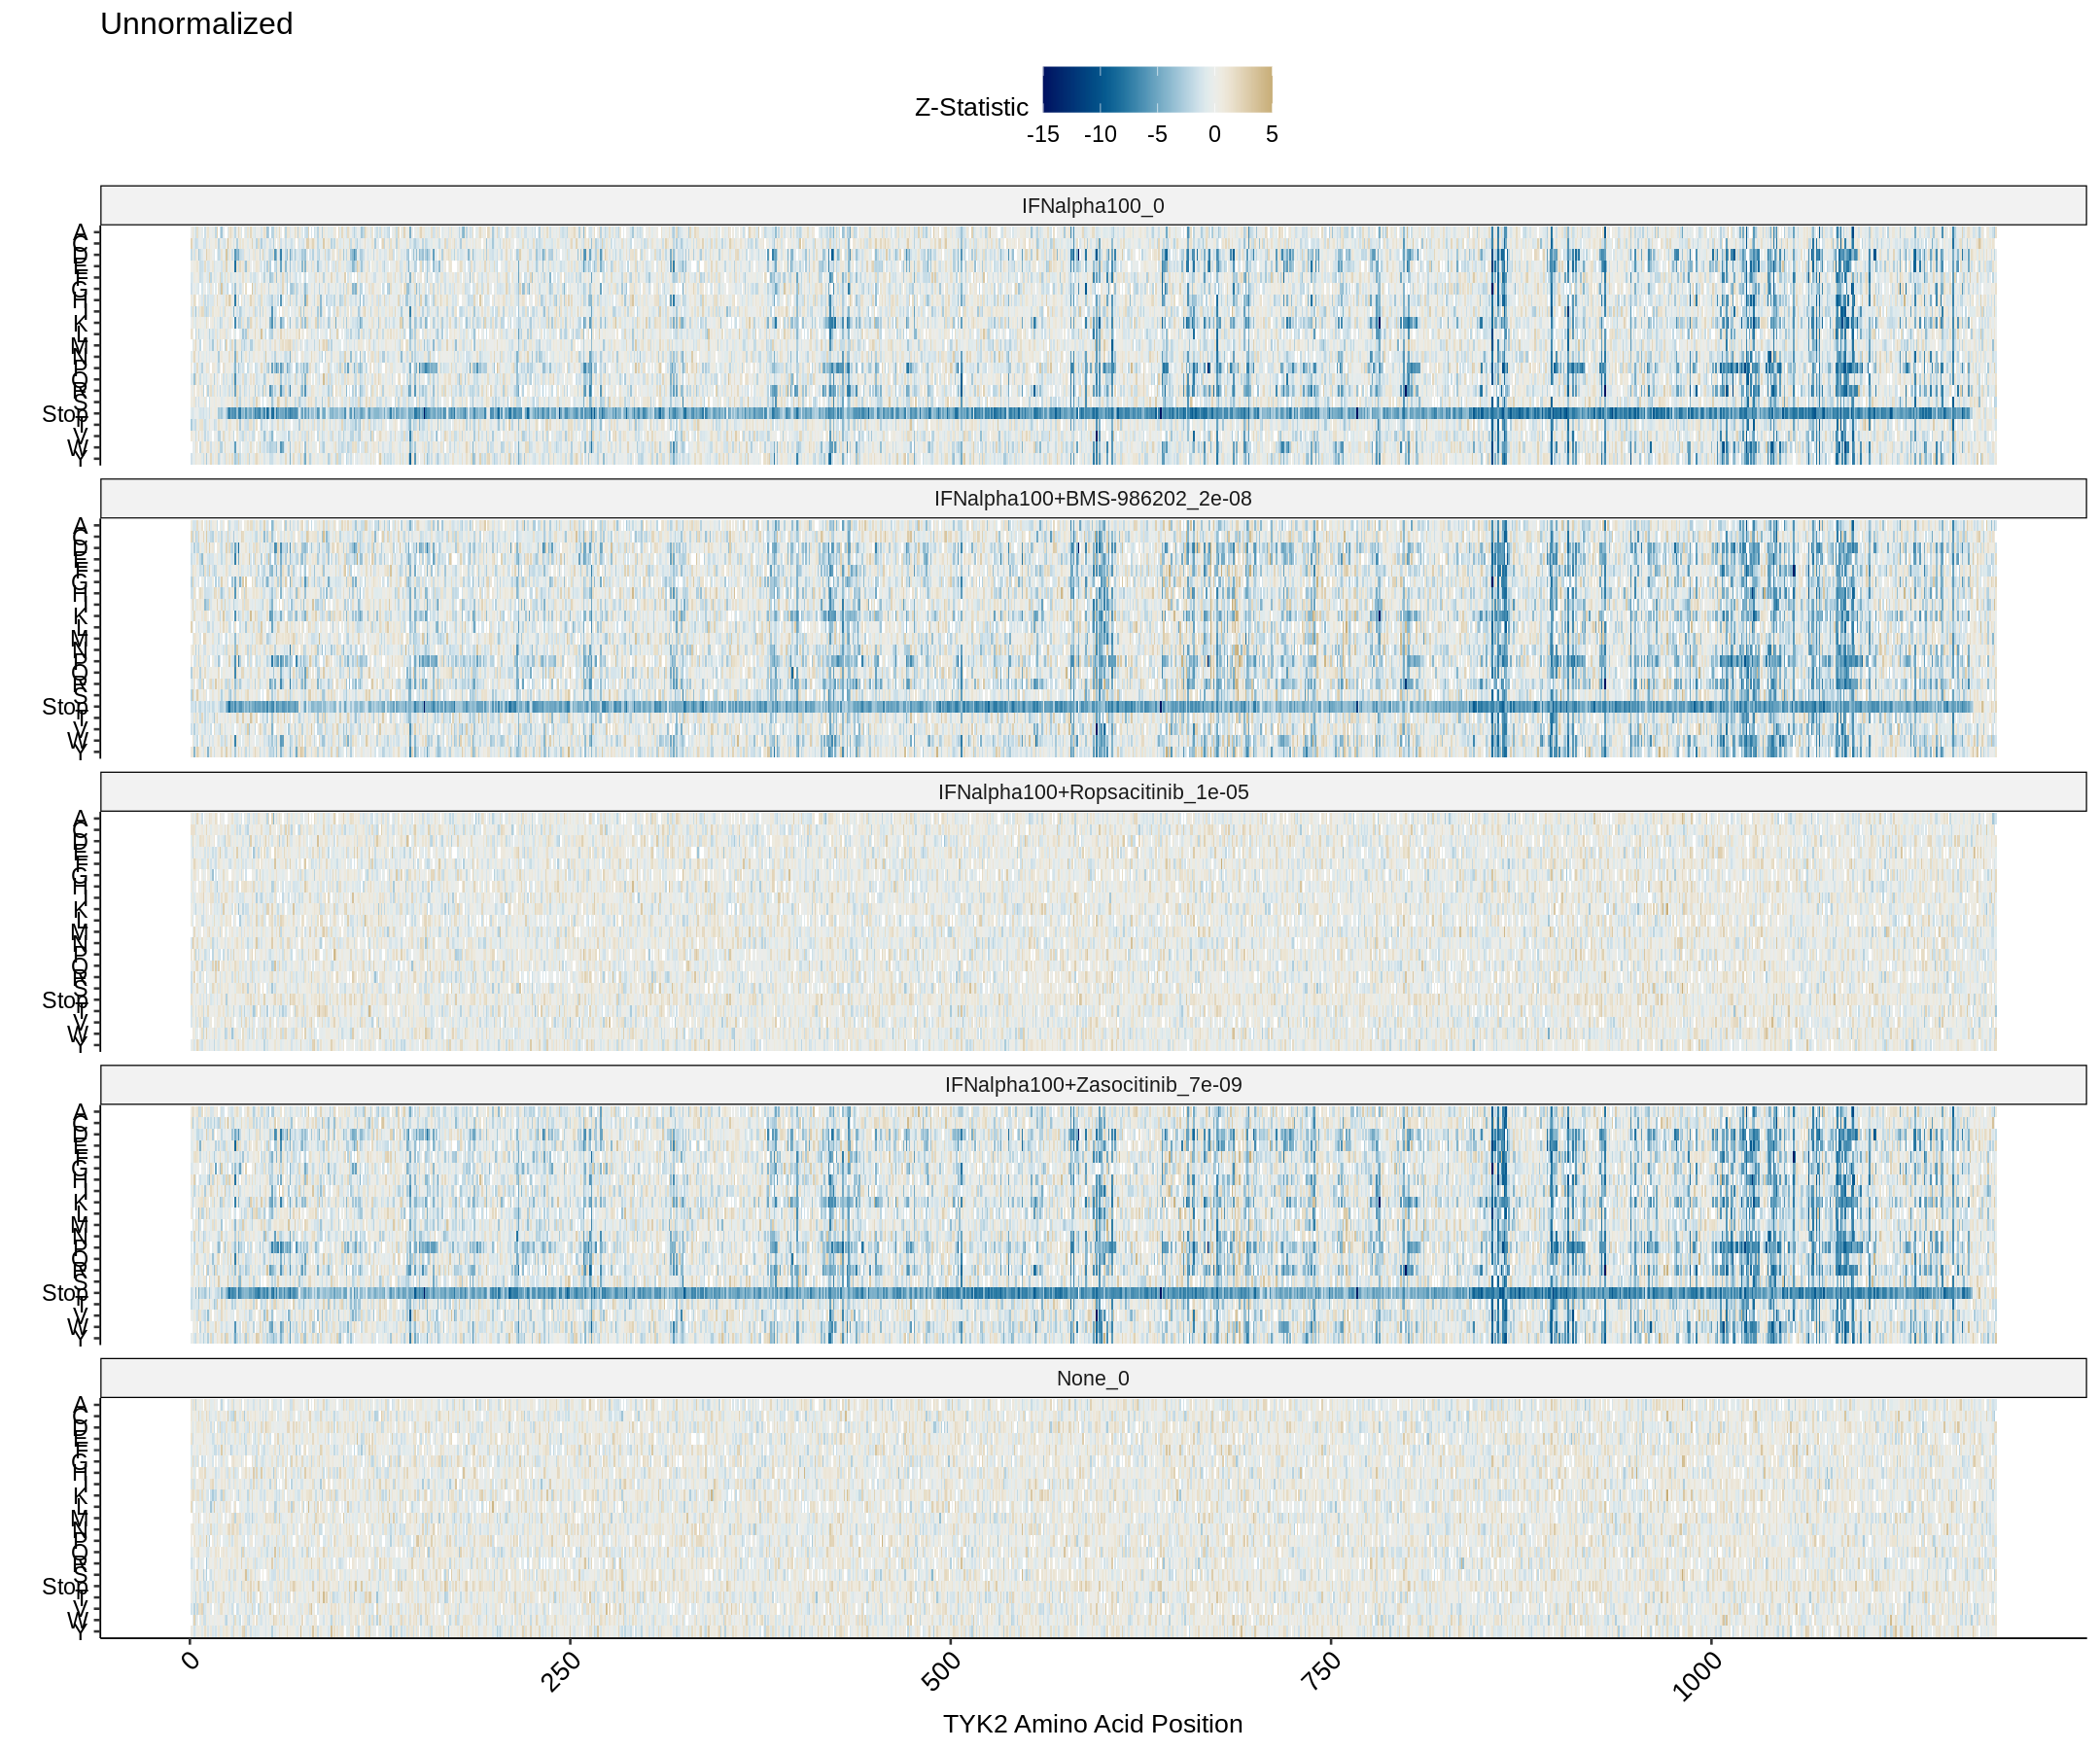

In [164]:
options(repr.plot.width = 18, repr.plot.height = 15)

sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("log2FoldChange" = "estimate") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =log2FoldChange)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Unnormalized")

sumstats %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Unnormalized")

In [ ]:
sumstats_all <- read_tsv("../sumstats/TYK2/run7/tyk2-assay7.tsv")

sumstats_all %>%
    filter(condition == "IFNalpha100_0 - None_0") %>%
    select(pos, chunk, aa, estimate, std.error, statistic, p.value, p.adj, condition) %>%
    rename("Position" = "pos", "Chunk" = "chunk", "AA" = "aa",
           "Log2FoldChange" = "estimate", "StandardError" = "std.error", "Statistic" = "statistic",
           "Pvalue" = "p.value", "Padj" = "p.adj", "Comparison" = "condition") %>%
    write_tsv("../sumstats/TYK2/BMS/IFNalpha100_vs_Untreated_Assay7.tsv")

In [17]:
norm_heat_l2fc <- sumstats_all %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =estimate)) +
            scale_fill_scico_mid(limits = c(-3,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to None")

norm_heat_z <- sumstats_all %>%
    mutate(aa = gsub("mut_aa", "", aa),
           aa = if_else(aa %in% c("*", "X"), "Stop", aa)) %>%
    rename("Z-Statistic" = "statistic") %>%
    ggplot() +
            geom_tile(aes(x = pos, y = fct_rev(aa), fill =`Z-Statistic`)) +
            scale_fill_scico_mid( limits = c(-15,5), palette = "vik", mid = 0, oob = squish) +
            theme_pubr(base_size = 16, x.text.angle = 45) +
            theme(legend.text=element_text(size=14),
                  legend.key.size = unit(1,"cm"),
                  axis.text.y = element_text(size = 14)) +
            ylab("") + xlab("TYK2 Amino Acid Position") +
            facet_wrap(~condition, ncol = 1) +
            ggtitle("Normalized to None")

ggsave("../TYK2-IFNaDMS-Assay7-L2FC.pdf", norm_heat_l2fc, width = 15, height = 18)
ggsave("../TYK2-IFNaDMS-Assay7-Z.pdf", norm_heat_z, width = 15, height = 18)

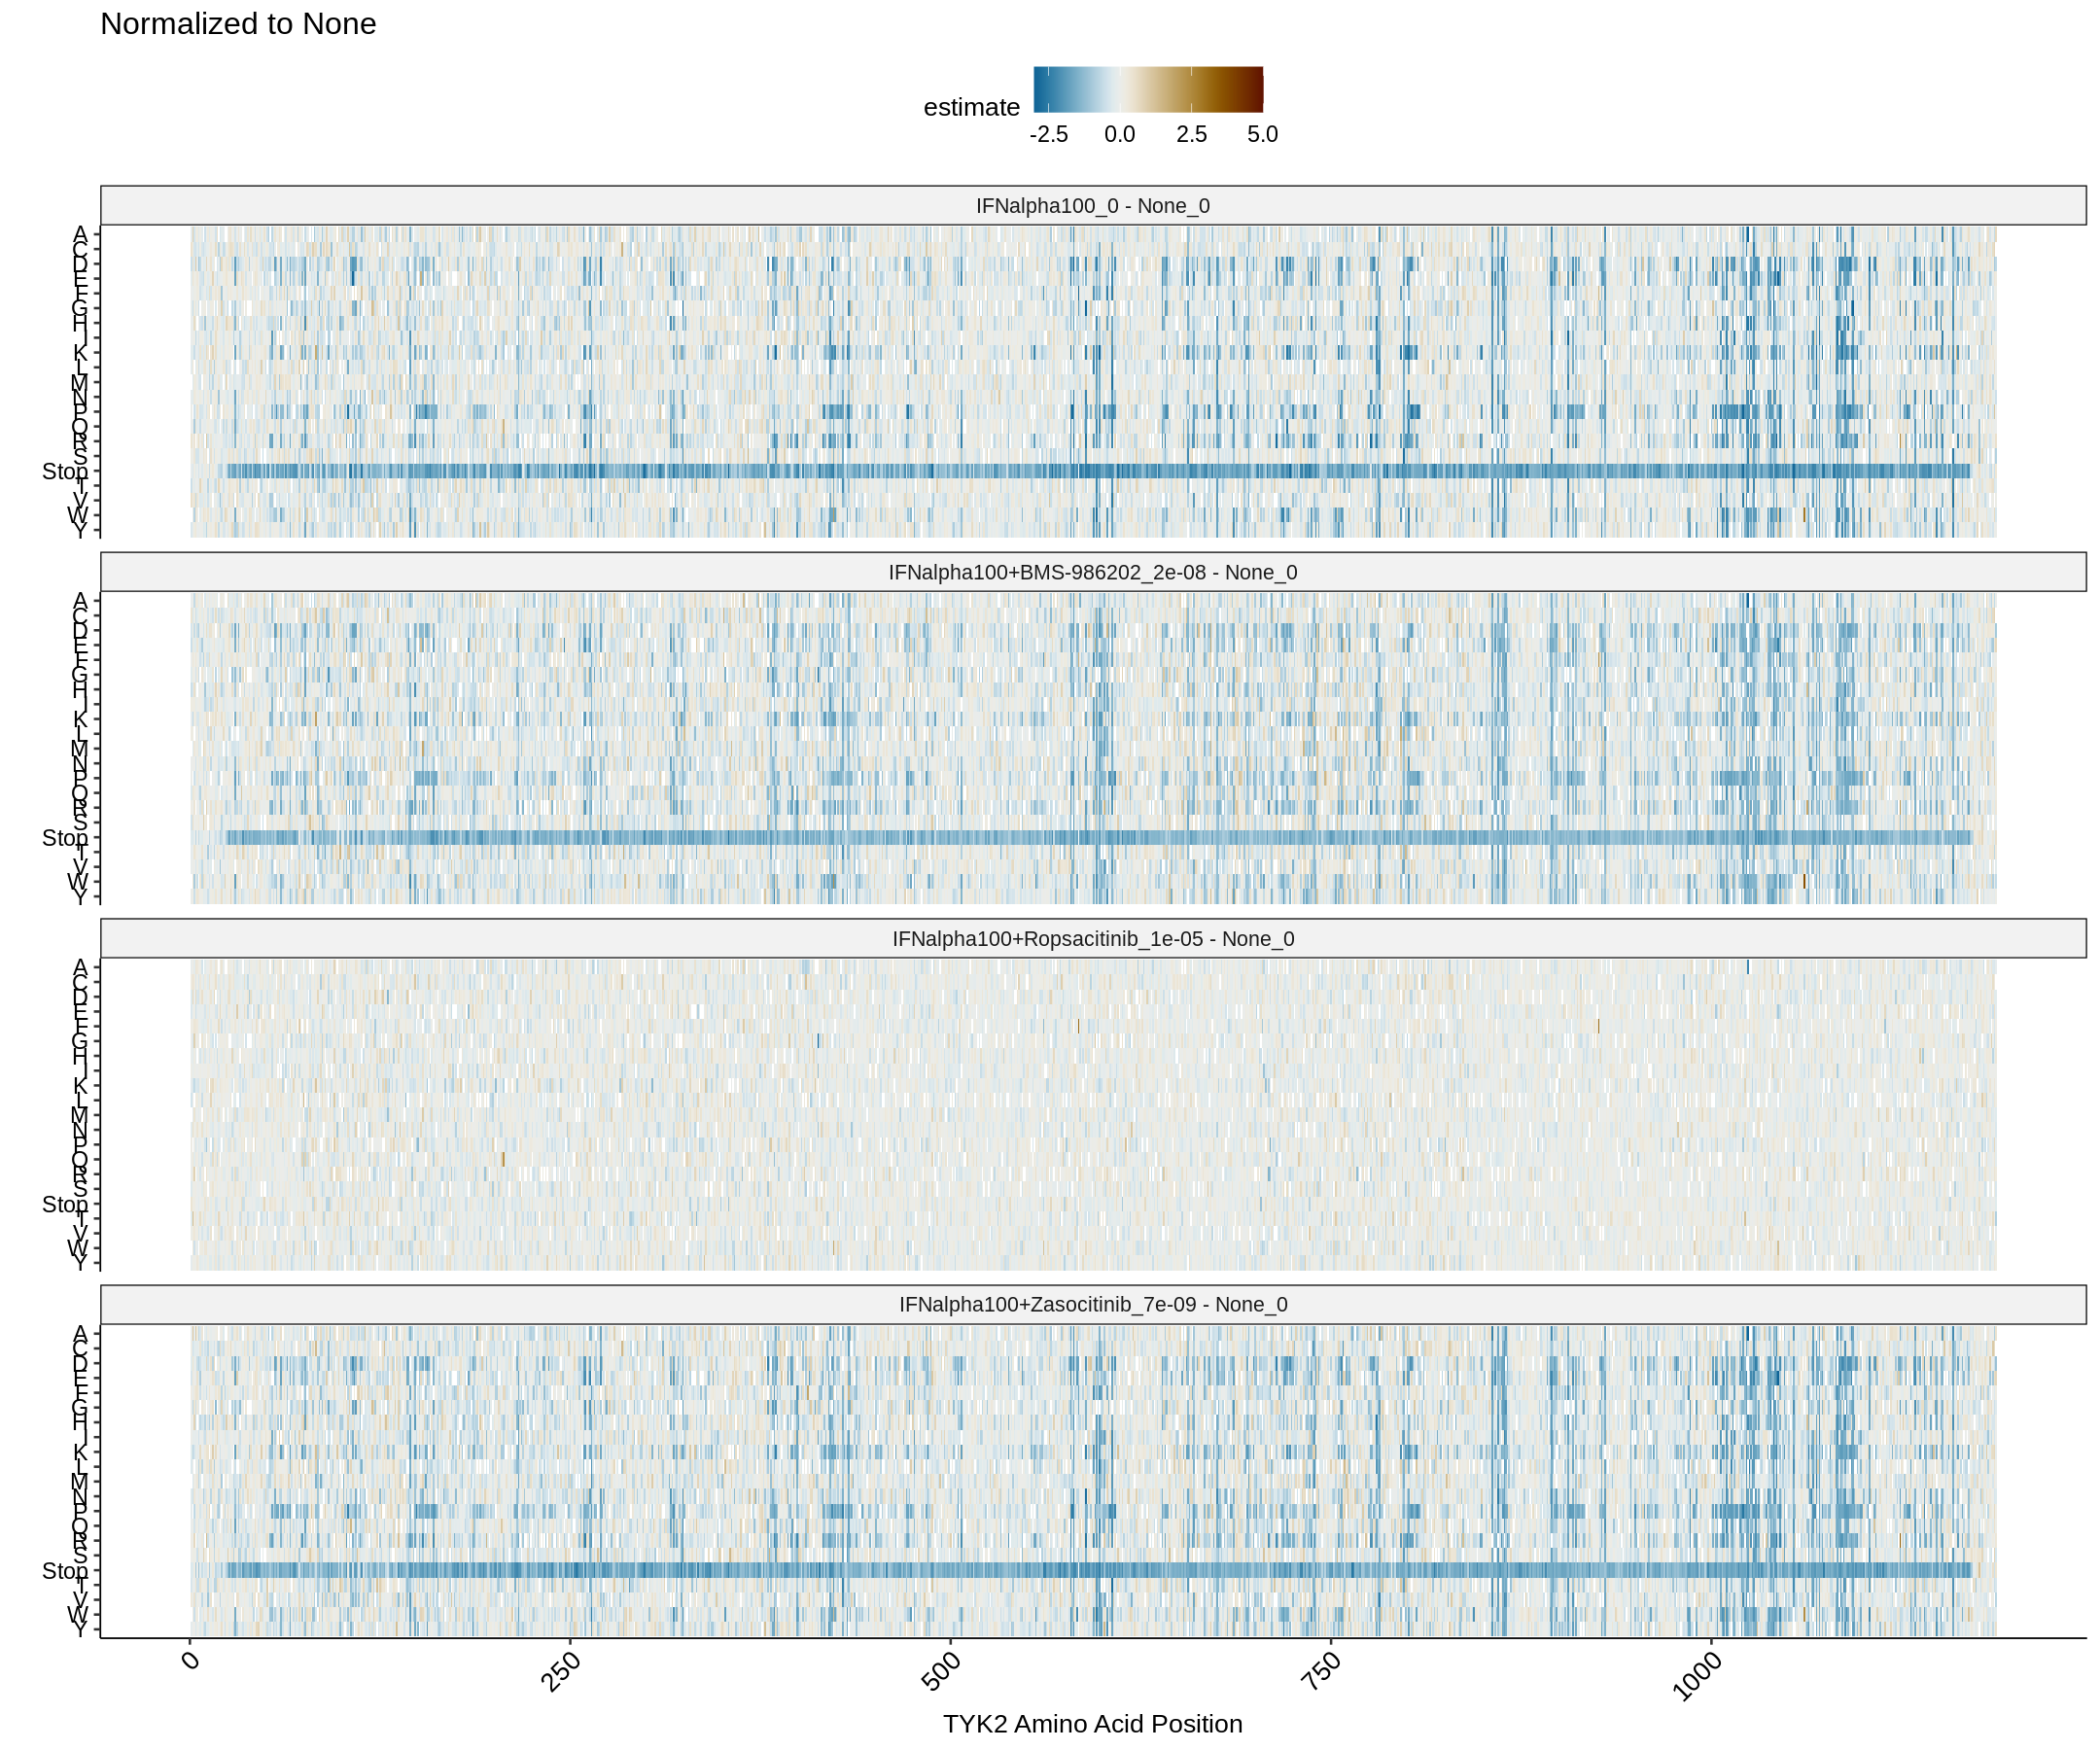

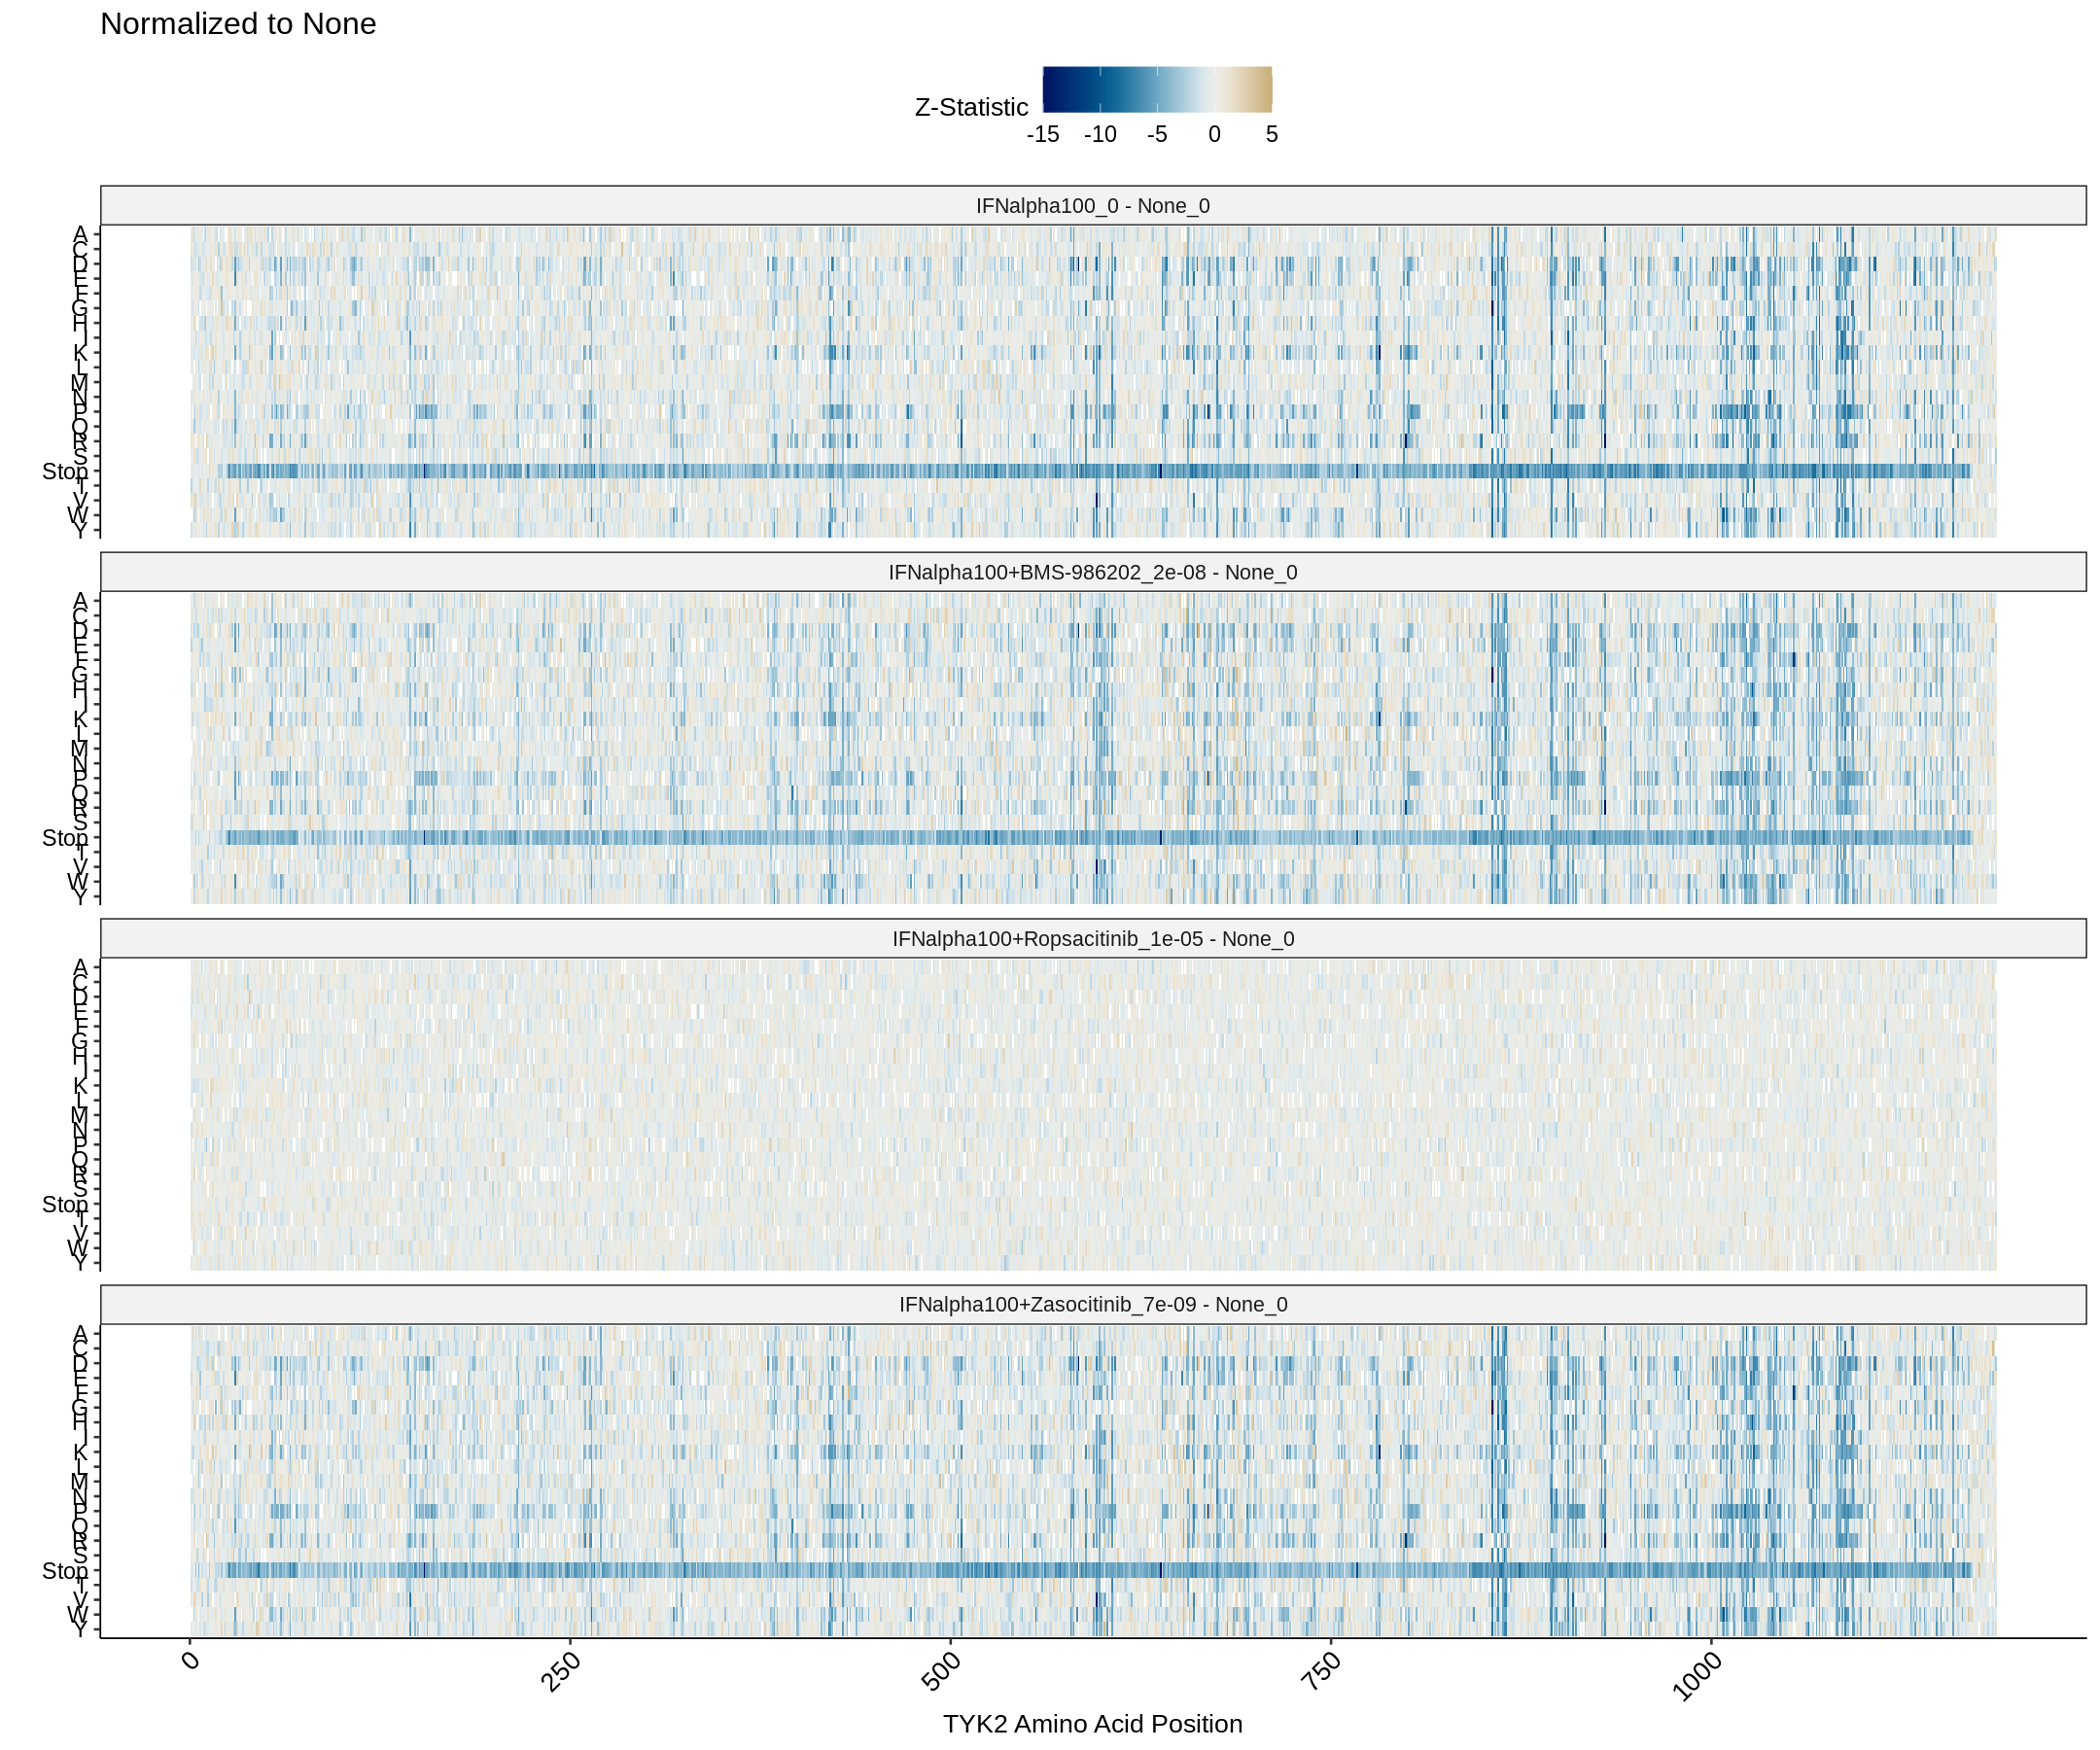

In [18]:
options(repr.plot.width = 18, repr.plot.height = 15)
norm_heat_l2fc
norm_heat_z

### Drug Resistance/Gain-of-Function <a name="part4"></a>

These are the GoF variants in each of the Normalized comparisons only (though we can also consider other variant sets). NOTE: No variants are significant in ropsacitinib after multiple testing adjustment at a 1% FDR, so the set using a 5% FDR is shown instead):

In [20]:
sumstats_all %>%
    filter(grepl("Ropsa", condition), estimate > 0, p.adj < 0.05) %>%
    select(condition, pos, aa, estimate, std.error, p.adj) %>%
    arrange(condition, pos, aa) %>%
    kable("markdown")

sumstats_all %>%
    filter(p.adj < 0.01, estimate > 0, grepl("Zaso", drug)) %>%
    select(condition, pos, aa, estimate, std.error, p.adj) %>%
    arrange(pos, aa) %>%
    kable("markdown")

sumstats_all %>%
    filter(p.adj < 0.01, estimate > 0, grepl("BMS", drug)) %>%
    select(condition, pos, aa, estimate, std.error, p.adj) %>%
    arrange(pos, aa) %>%
    kable("markdown")



|condition                               |  pos|aa |  estimate| std.error|     p.adj|
|:---------------------------------------|----:|:--|---------:|---------:|---------:|
|IFNalpha100+Ropsacitinib_1e-05 - None_0 |  206|Q  | 2.2780633| 0.7575796| 0.0259833|
|IFNalpha100+Ropsacitinib_1e-05 - None_0 |  619|N  | 1.0520914| 0.3403100| 0.0203425|
|IFNalpha100+Ropsacitinib_1e-05 - None_0 |  968|K  | 0.8167298| 0.2597208| 0.0173715|
|IFNalpha100+Ropsacitinib_1e-05 - None_0 | 1022|T  | 1.2411171| 0.3744781| 0.0103734|



|condition                              |  pos|aa |  estimate| std.error|     p.adj|
|:--------------------------------------|----:|:--|---------:|---------:|---------:|
|IFNalpha100+Zasocitinib_7e-09 - None_0 |   11|R  | 1.3354086| 0.3436159| 0.0014902|
|IFNalpha100+Zasocitinib_7e-09 - None_0 |  195|R  | 1.4756881| 0.4112868| 0.0042479|
|IFNalpha100+Zasocitinib_7e-09 - None_0 |  352|L  | 1.2441683| 0.3508074| 0.0048827|
|IFNalpha100+Zasocitinib_7e-09 - None_0 |  406|F  | 1.8410739| 0.5375922| 0.0072765|
|IFNalpha100+Zasocitinib_7e-09 - None_0 |  433|F  | 1.3304065| 0.3391751| 0.0013068|
|IFNalpha100+Zasocitinib_7e-09 - None_0 |  466|H  | 0.9381169| 0.2587520| 0.0037379|
|IFNalpha100+Zasocitinib_7e-09 - None_0 |  493|M  | 1.0533474| 0.2862793| 0.0031099|
|IFNalpha100+Zasocitinib_7e-09 - None_0 |  601|Y  | 1.4157983| 0.3333802| 0.0003833|
|IFNalpha100+Zasocitinib_7e-09 - None_0 |  603|M  | 0.9264659| 0.2623005| 0.0051316|
|IFNalpha100+Zasocitinib_7e-09 - None_0 |  647|K  | 0.9037614| 



|condition                             | pos|aa |  estimate| std.error|     p.adj|
|:-------------------------------------|---:|:--|---------:|---------:|---------:|
|IFNalpha100+BMS-986202_2e-08 - None_0 | 153|M  | 1.8293450| 0.5146748| 0.0047568|
|IFNalpha100+BMS-986202_2e-08 - None_0 | 244|E  | 0.7975916| 0.2276530| 0.0056358|
|IFNalpha100+BMS-986202_2e-08 - None_0 | 355|N  | 0.9663929| 0.2738238| 0.0051793|
|IFNalpha100+BMS-986202_2e-08 - None_0 | 499|G  | 0.9173240| 0.2681003| 0.0073525|
|IFNalpha100+BMS-986202_2e-08 - None_0 | 526|L  | 0.9511076| 0.2832255| 0.0090244|
|IFNalpha100+BMS-986202_2e-08 - None_0 | 595|E  | 1.4515672| 0.3962894| 0.0032962|
|IFNalpha100+BMS-986202_2e-08 - None_0 | 595|Q  | 1.3129935| 0.3620009| 0.0037193|
|IFNalpha100+BMS-986202_2e-08 - None_0 | 601|R  | 1.4081499| 0.3530226| 0.0010228|
|IFNalpha100+BMS-986202_2e-08 - None_0 | 603|D  | 1.4026799| 0.3447459| 0.0007587|
|IFNalpha100+BMS-986202_2e-08 - None_0 | 640|G  | 1.1287267| 0.2867421| 0.0012426|
|I

The stop effect is weird to see in this context - lets look at that stop in all conditions:

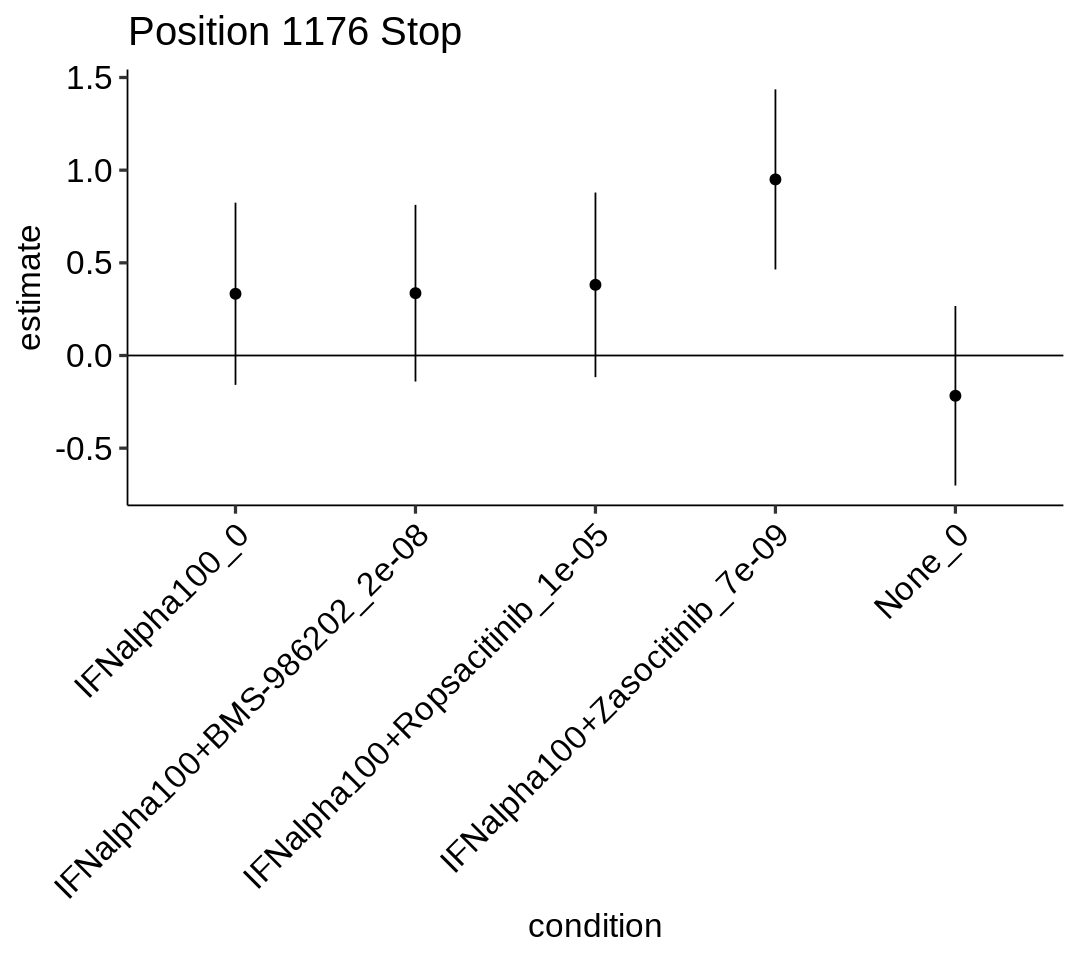

In [21]:
options(repr.plot.width = 9, repr.plot.height = 8)
sumstats %>%
    filter(pos == 1176, aa == "*") %>%
    ggplot() +
        geom_pointrange(aes(x = condition, y = estimate,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error)) +
        theme_pubr(base_size = 20, x.text.angle = 45) +
        geom_hline(yintercept = 0) +
        ggtitle("Position 1176 Stop")


It is significant, but is in the region of stops at the end of the protein that generally dont show a LoF effect from stop codons:

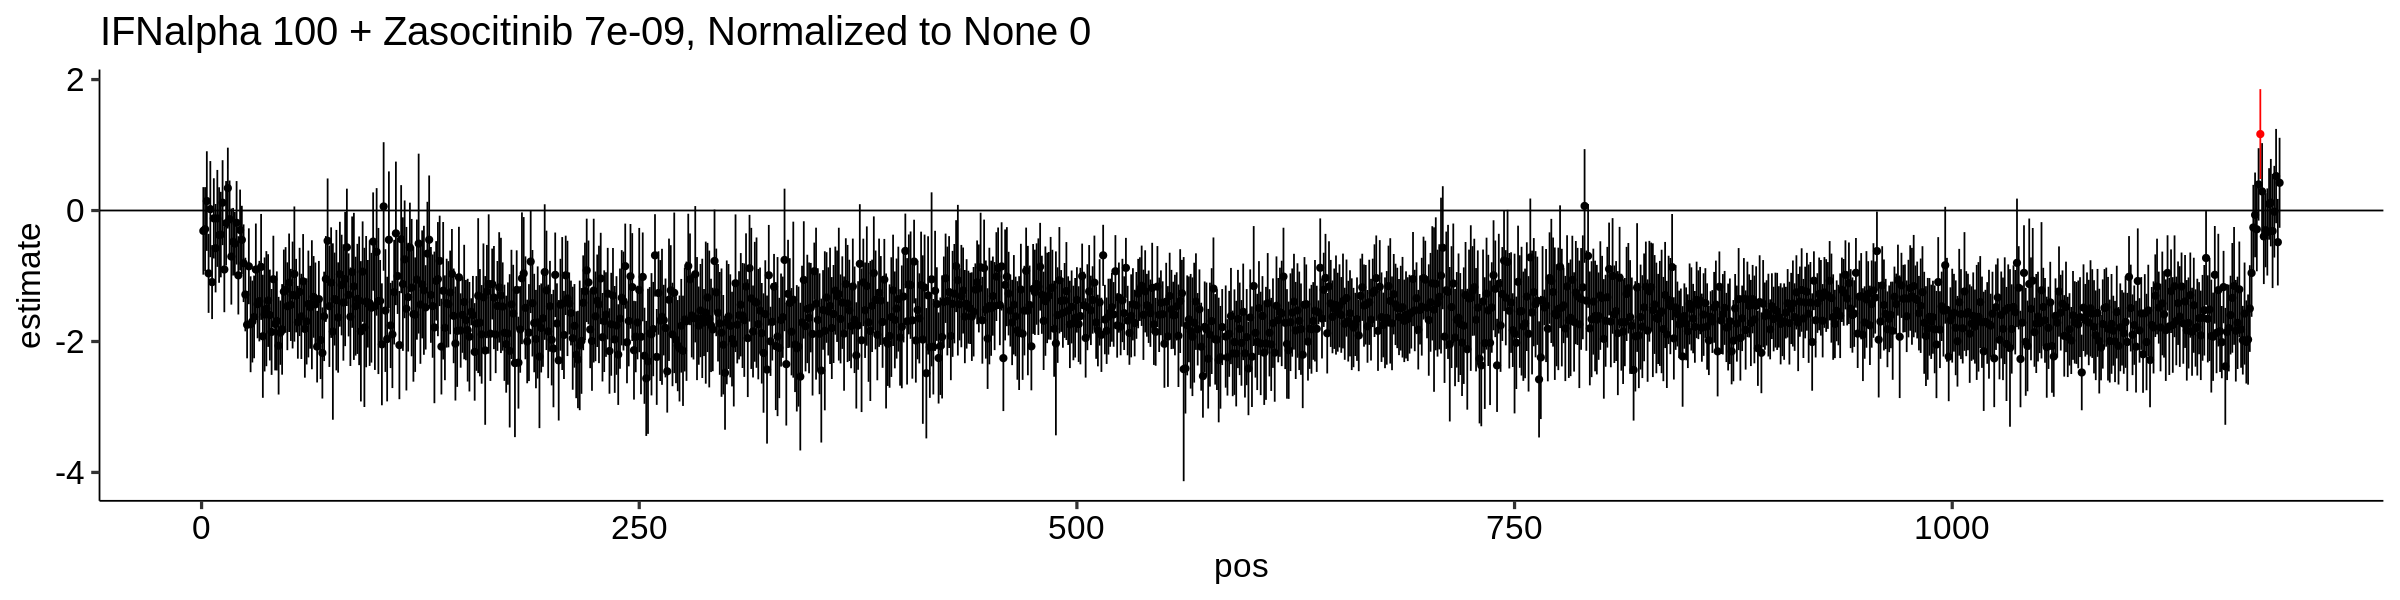

In [22]:
options(repr.plot.width = 20, repr.plot.height = 5)
sumstats_all %>%
    filter(aa == "*", condition == "IFNalpha100+Zasocitinib_7e-09 - None_0") %>%
    ggplot() +
        geom_pointrange(aes(x = pos, y = estimate,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error,
                            color = if_else(pos == 1176, "red", "black")), size = 0.25) +
        theme_pubr(base_size = 20) +
        scale_color_identity() +
        geom_hline(yintercept = 0) +
        ggtitle("IFNalpha 100 + Zasocitinib 7e-09, Normalized to None 0")

### Drug Potentiation <a name="part5"></a>

In [3]:
sumstats <- read_tsv("../sumstats/TYK2/run7/tyk2-assay7-unnormalized.tsv")

Rows: 118595 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): clone, chunk, condition, aa, version, drug
dbl (8): pos, estimate, std.error, statistic, p.value, dispersion, conc, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
bms_poten <- compute_difference(test = "IFNalpha100+BMS-986202_2e-08",
                                control = "IFNalpha100_0",
                                sumstats) 

zaso_poten <- compute_difference(test = "IFNalpha100+Zasocitinib_7e-09",
                                control = "IFNalpha100_0",
                                sumstats) 

potentiation_sumstats <- bind_rows(bms_poten, zaso_poten) %>%
    mutate(statistic = estimate / std.error,
           p.value = pmin(pnorm(statistic, mean = 0, sd = 1)*2,
                                 (1-pnorm(statistic, sd = 1))*2),
           p.adj = p.adjust(p.value, method = "BH")) 

In [43]:
sumstats_volcano <- potentiation_sumstats %>%
    filter(condition == "IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0") %>%
    mutate(lab = str_c(pos, aa),
           lab1 = if_else(p.adj < 0.01 & estimate < 0, lab, ""),
           lab2 = if_else(p.adj < 0.01 & estimate > 0, lab, ""))

volcano_plot <- ggplot() +
    geom_hline(yintercept = -log10(0.01), color = "red") +
    geom_point(data = sumstats_volcano,
               aes(x = estimate, y = -log10(p.adj),
                   color = if_else(-log10(p.adj) >= 2, "red", "black")),
               size = 2) +
    geom_label_repel(data = sumstats_volcano,
               aes(x = estimate, y = -log10(p.adj), label = lab1),
               color = "red", size = 5, direction = "y",
                     ylim = c(2,Inf), nudge_x = -2.5 - sumstats_volcano$estimate,
                     force = 3) +
    theme_pubr(base_size = 16) +
    xlab("Log2 Fold Change") + ylab("-log10(FDR)") +
    scale_color_identity() +
    coord_cartesian(ylim = c(0,11)) +
    ggtitle("IFN-alpha + BMS-986202 (2e-08), Normalized to IFN-alpha") +
    coord_cartesian(xlim = c(-2.5, 2.25))

ggsave("../dataviz/TYK2/ifna/TYK2-IFNaDMS-Assay7-DrugPotentiateVolcano.pdf",
       volcano_plot,
       width = 8, height = 9)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


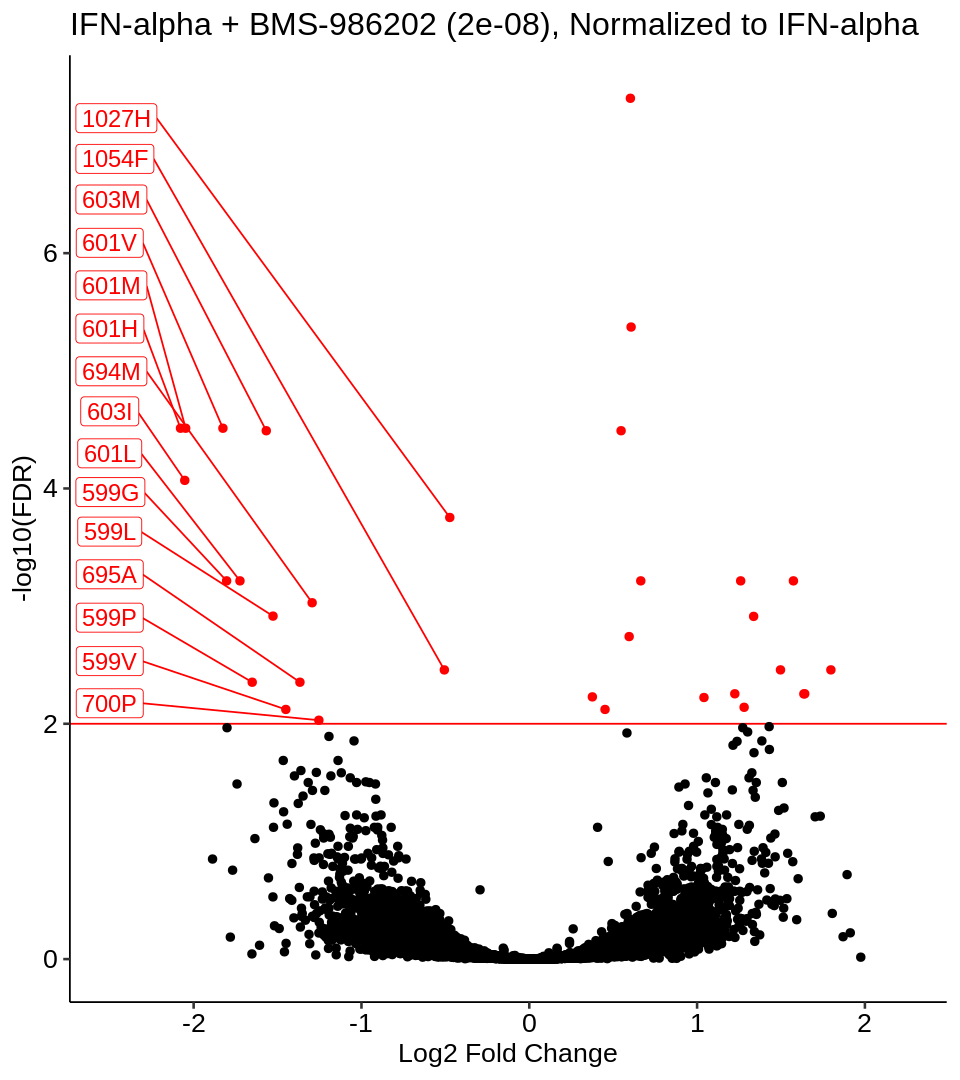

In [44]:
options(repr.plot.width = 8, repr.plot.height = 9)
volcano_plot

In [5]:
potentiation_sumstats %>%
    filter(condition == "IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0") %>%
    filter(estimate < 0, p.adj < 0.01) %>%
    select(condition, pos, aa, estimate, p.adj) %>%
    arrange(pos)

potentiation_sumstats %>%
    filter(condition == "IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0") %>%
    filter(estimate < 0, p.adj < 0.01) %>%
    select(condition, pos, aa, estimate, p.adj) %>%
    arrange(pos)

condition                                    pos  aa estimate   p.adj       
1  IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  599 G  -1.8035622 6.100411e-04
2  IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  599 L  -1.5270272 1.215985e-03
3  IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  599 P  -1.6510140 4.435032e-03
4  IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  599 V  -1.4506621 7.554739e-03
5  IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  601 H  -2.0782209 3.076257e-05
6  IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  601 L  -1.7240052 6.100411e-04
7  IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  601 M  -2.0475156 3.076257e-05
8  IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  601 V  -1.8255167 3.076257e-05
9  IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  603 I  -2.0529038 8.535143e-05
10 IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  603 M  -1.5672314 3.230773e-05
11 IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  694 M  -1.2939152 9.361203e-04
12 IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  695 A  -1.3666114 4.435032e-03
13 IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0  700 P  -1.2537972 9.329562e-03
14 IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0 1027 H  -0.4736837 1.764537e-04
15 IFNalpha100+BMS-986202_2e-08 - IFNalpha100_0 1054 F  -0.5060788 3.485076e-03

condition                                     pos  aa estimate  
1  IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  599 I  -1.5560720
2  IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  599 L  -1.4684695
3  IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  599 W  -1.6593759
4  IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  601 C  -1.4847910
5  IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  601 L  -1.5589389
6  IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  601 M  -1.7266992
7  IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  601 Q  -1.5118940
8  IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  601 V  -1.4241021
9  IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  695 Y  -1.1812582
10 IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  739 H  -1.9774349
11 IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  739 M  -1.9799465
12 IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  758 C  -2.7664630
13 IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  865 G  -1.1765818
14 IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  894 V  -1.1996357
15 IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0  898 I  -1.1141530
16 IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0 1027 H  -0.5002964
17 IFNalpha100+Zasocitinib_7e-09 - IFNalpha100_0 1054 F  -0.4967717
   p.adj       
1  2.599568e-03
2  3.485076e-03
3  3.200807e-03
4  9.662656e-03
5  4.038811e-03
6  1.683330e-03
7  7.734799e-04
8  7.871992e-03
9  5.908045e-03
10 1.984626e-03
11 9.321175e-04
12 7.038339e-05
13 4.035112e-03
14 4.881949e-03
15 8.734296e-03
16 5.862812e-05
17 4.435032e-03

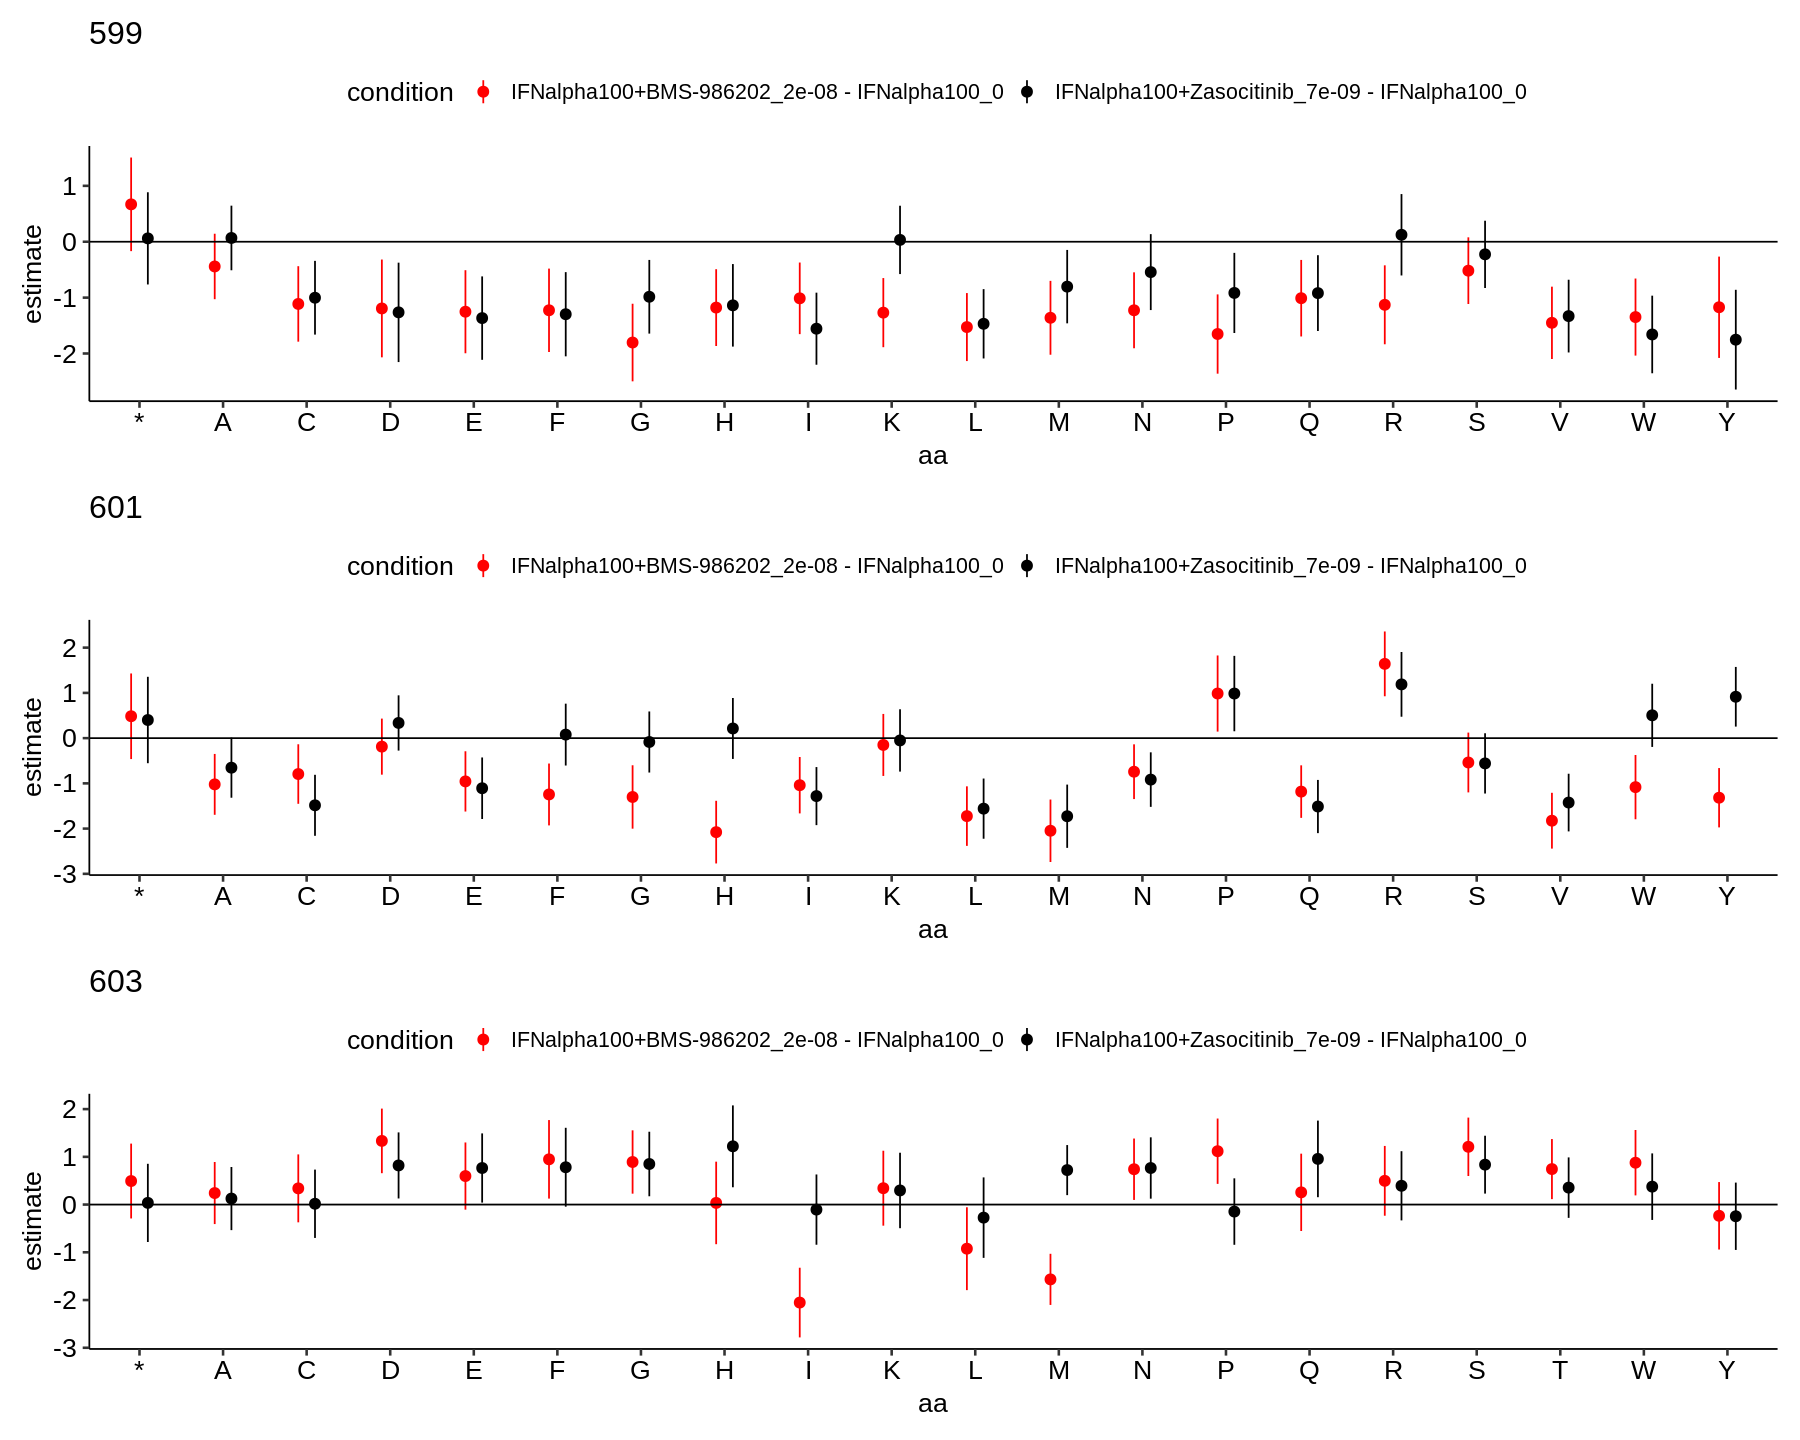

In [201]:
make_profile <- function(poss, df){
    
    p1 <- df %>%
        filter(pos == poss) %>%
        ggplot() +
            geom_pointrange(aes(x = aa, y = estimate, color = condition,
                                ymin = estimate - 2*std.error,
                                ymax = estimate + 2*std.error),
                            position = position_dodge(width = 0.4)) +
            theme_pubr(base_size = 16) +
            geom_hline(yintercept = 0) + ggtitle(poss) +
            scale_color_manual(values = c("red", "black"))

    return(p1)
}

options(repr.plot.width = 15, repr.plot.height = 12)
make_profile(599, bind_rows(bms_poten, zaso_poten)) /
    make_profile(601, bind_rows(bms_poten, zaso_poten)) /
    make_profile(603, bind_rows(bms_poten, zaso_poten))

To contextualize the significant hits in the context of the underlying variant profile across conditions, we can plot the Z-statistics of IFN-alpha and each drug separately, but then highlight the significant variants by the contrast:

In [5]:
compare_potentiation <- function(siglist, conds, labels, colors, color_col, df){

    df_wide <- df %>%
        filter(condition %in% conds) %>%
        select(pos, aa, statistic, p.adj, condition) %>%
        pivot_wider(names_from = condition, values_from = c(statistic, p.adj)) %>%
        rename("stat1" = str_c("statistic_", conds[1]),
               "stat2" = str_c("statistic_", conds[2]),
               "p1" = str_c("p.adj_", conds[1]),
               "p2" = str_c("p.adj_", conds[2])) %>%
        mutate("FDR < 0.01" = case_when(p1 < 0.01 & p2 > 0.01 ~ labels[1],
                               p1 > 0.01 & p2 < 0.01 ~ labels[2],
                               p1 < 0.01 & p2 < 0.01 ~ "Both",
                               TRUE ~ "Neither"),
               "Stop Group" = if_else(aa == "*", "Stop", "Non-Stop"),
               "Contrast FDR < 0.01" = if_else(str_c(pos, aa) %in% siglist,
                                               "Significant",
                                               "NonSignificant")) %>%
        rename("color_col" = color_col)
    
    the_plot <- ggplot(df_wide, aes(x = stat1,
                             y = stat2, color = color_col)) +
        geom_point(size = 3) +
        theme_pubr(base_size = 20) +
        geom_abline(slope = 1, intercept = 0) +
        geom_hline(yintercept = 0) +
        geom_vline(xintercept = 0) +
        theme(legend.pos = "left") +
        xlab(labels[1]) + ylab(labels[2]) +
        geom_xsidedensity(aes(y = stat(density),
                              fill = `Stop Group`), color = NA, alpha = 0.5) +
        geom_ysidedensity(aes(x = stat(density),
                              fill =`Stop Group`), color = NA, alpha = 0.5) +
        theme(ggside.panel.scale.x = 0.25,
              ggside.panel.scale.y = 0.25) +
        scale_fill_manual(values = c("Stop" = "red", "Non-Stop" = "gray")) +
        scale_color_manual(values = colors, name = color_col) + 
        guides(colour = guide_legend(override.aes = list(size=7)))

    return(the_plot)
}

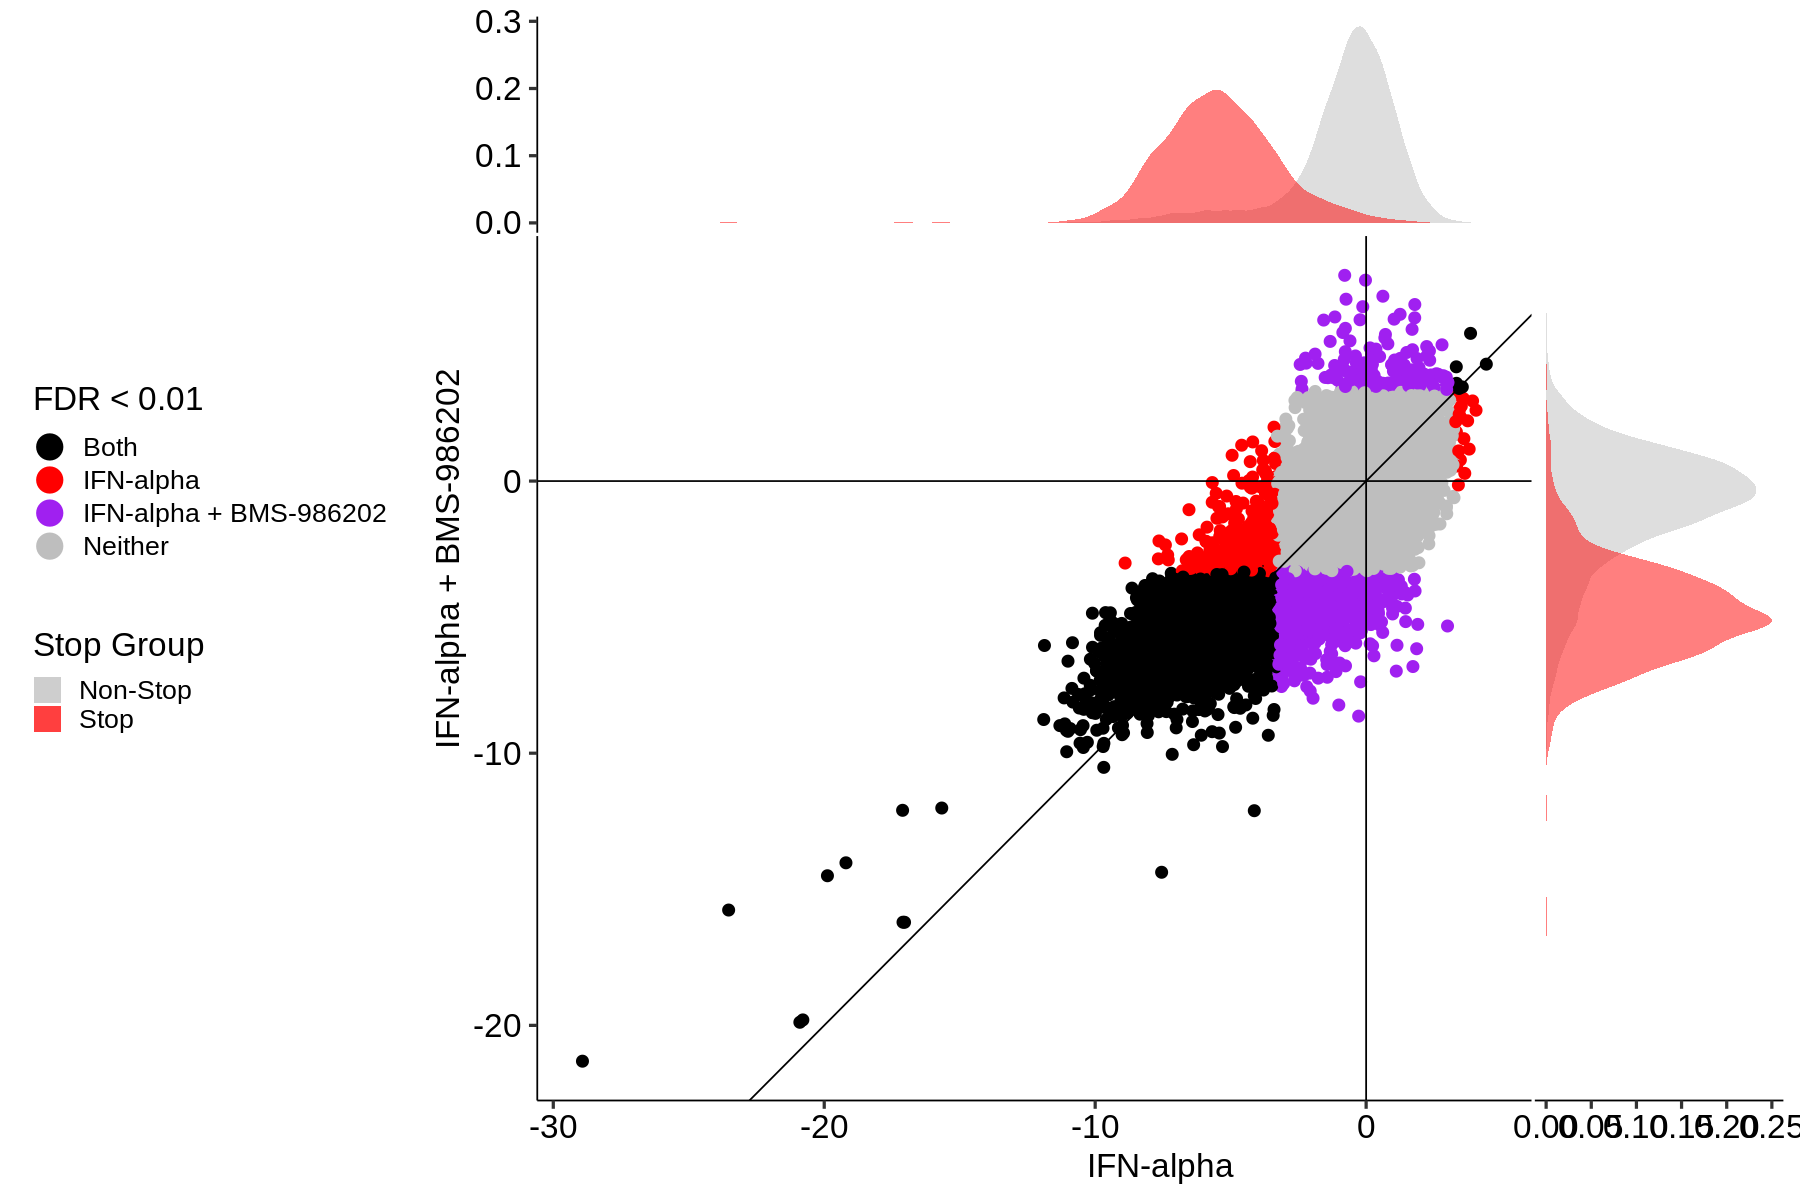

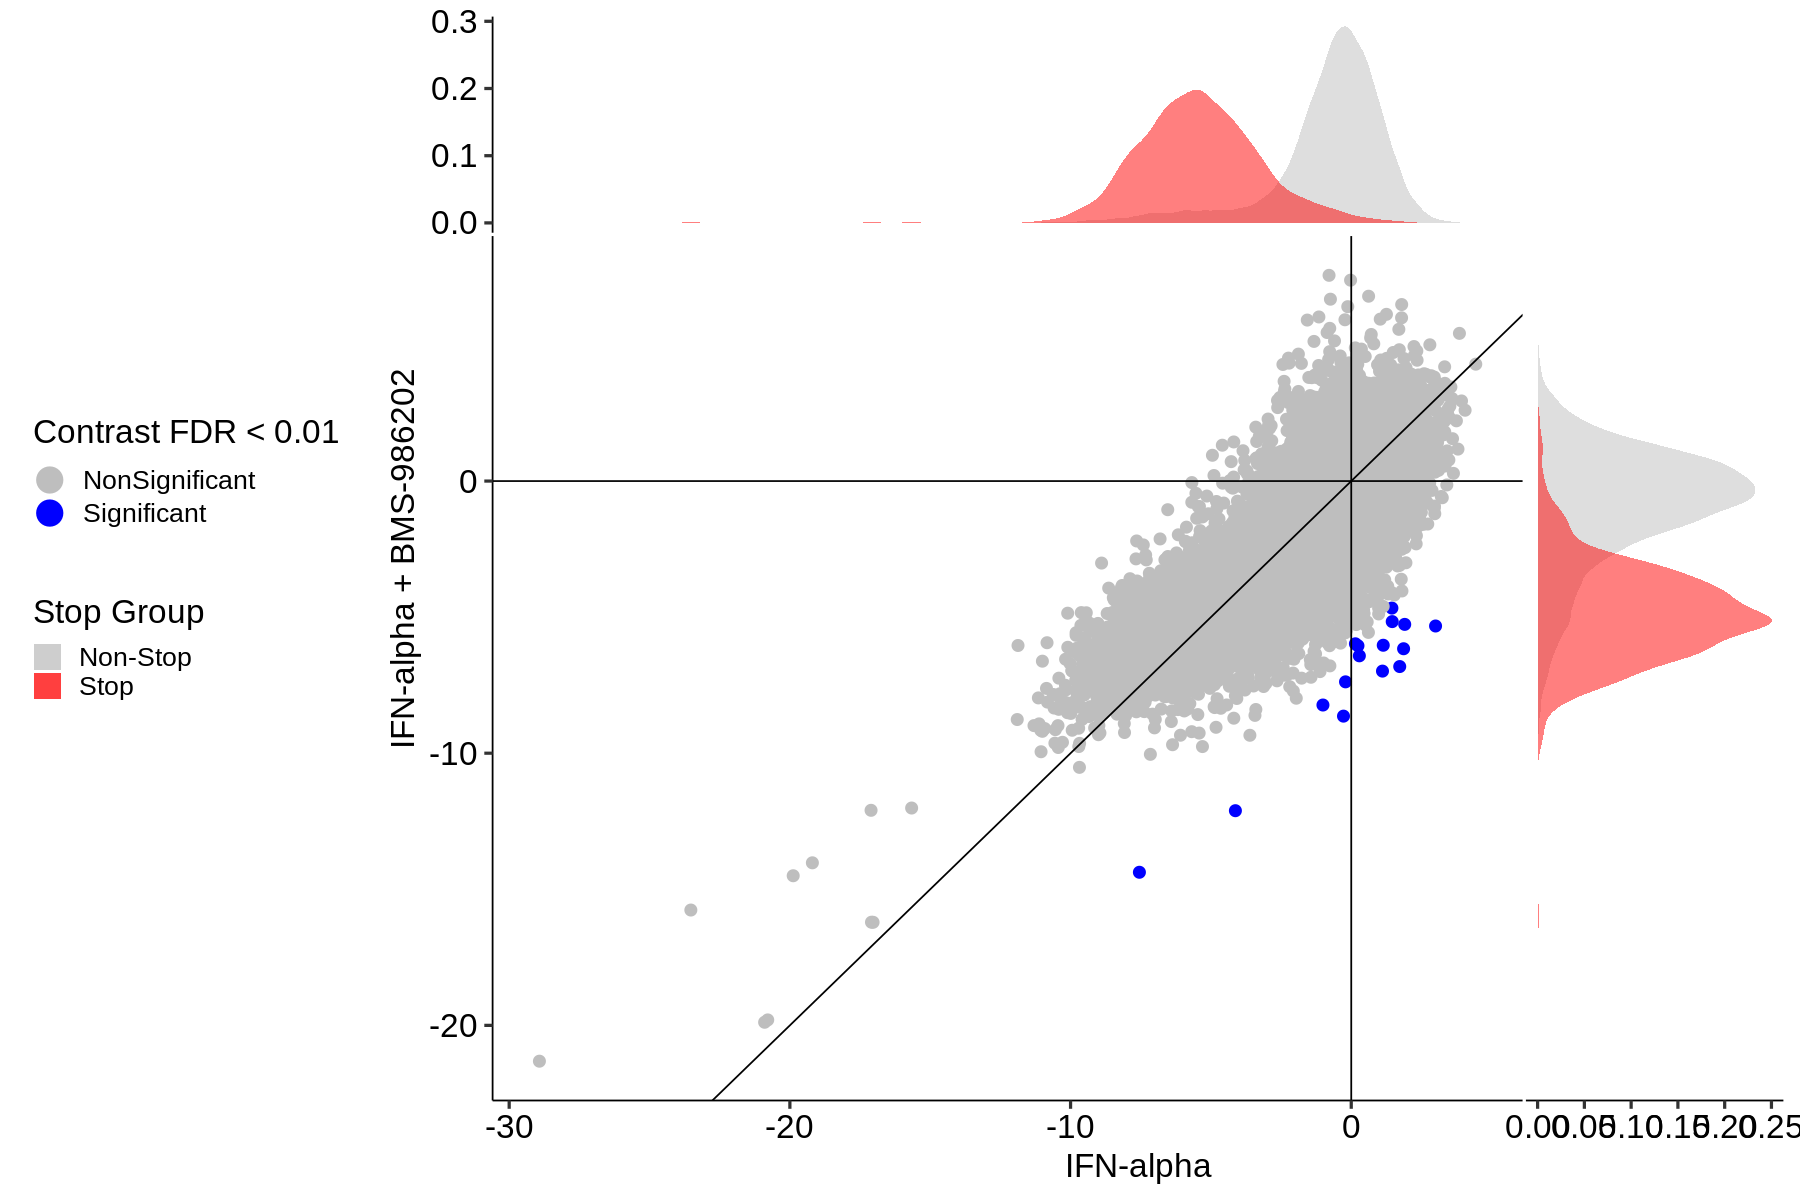

In [182]:
options(repr.plot.width = 15, repr.plot.height = 10)

bms_siglist <- bms_poten %>%
    filter(estimate < 0, p.adj < 0.01) %>%
    mutate(mut_id = str_c(pos, aa)) %>% pull(mut_id)

conds <- c("IFNalpha100_0", "IFNalpha100+BMS-986202_2e-08")
labels <- c("IFN-alpha", "IFN-alpha + BMS-986202")

colors <- c("black", "red", "purple","gray")
names(colors) <- c("Both", labels[1], labels[2], "Neither")

compare_potentiation(bms_siglist, conds, labels, colors, "FDR < 0.01", sumstats)

contrast_colors <- c("grey", "blue")
names(contrast_colors) <- c("NonSignificant", "Significant")

compare_potentiation(bms_siglist, conds, labels, contrast_colors, "Contrast FDR < 0.01", sumstats)

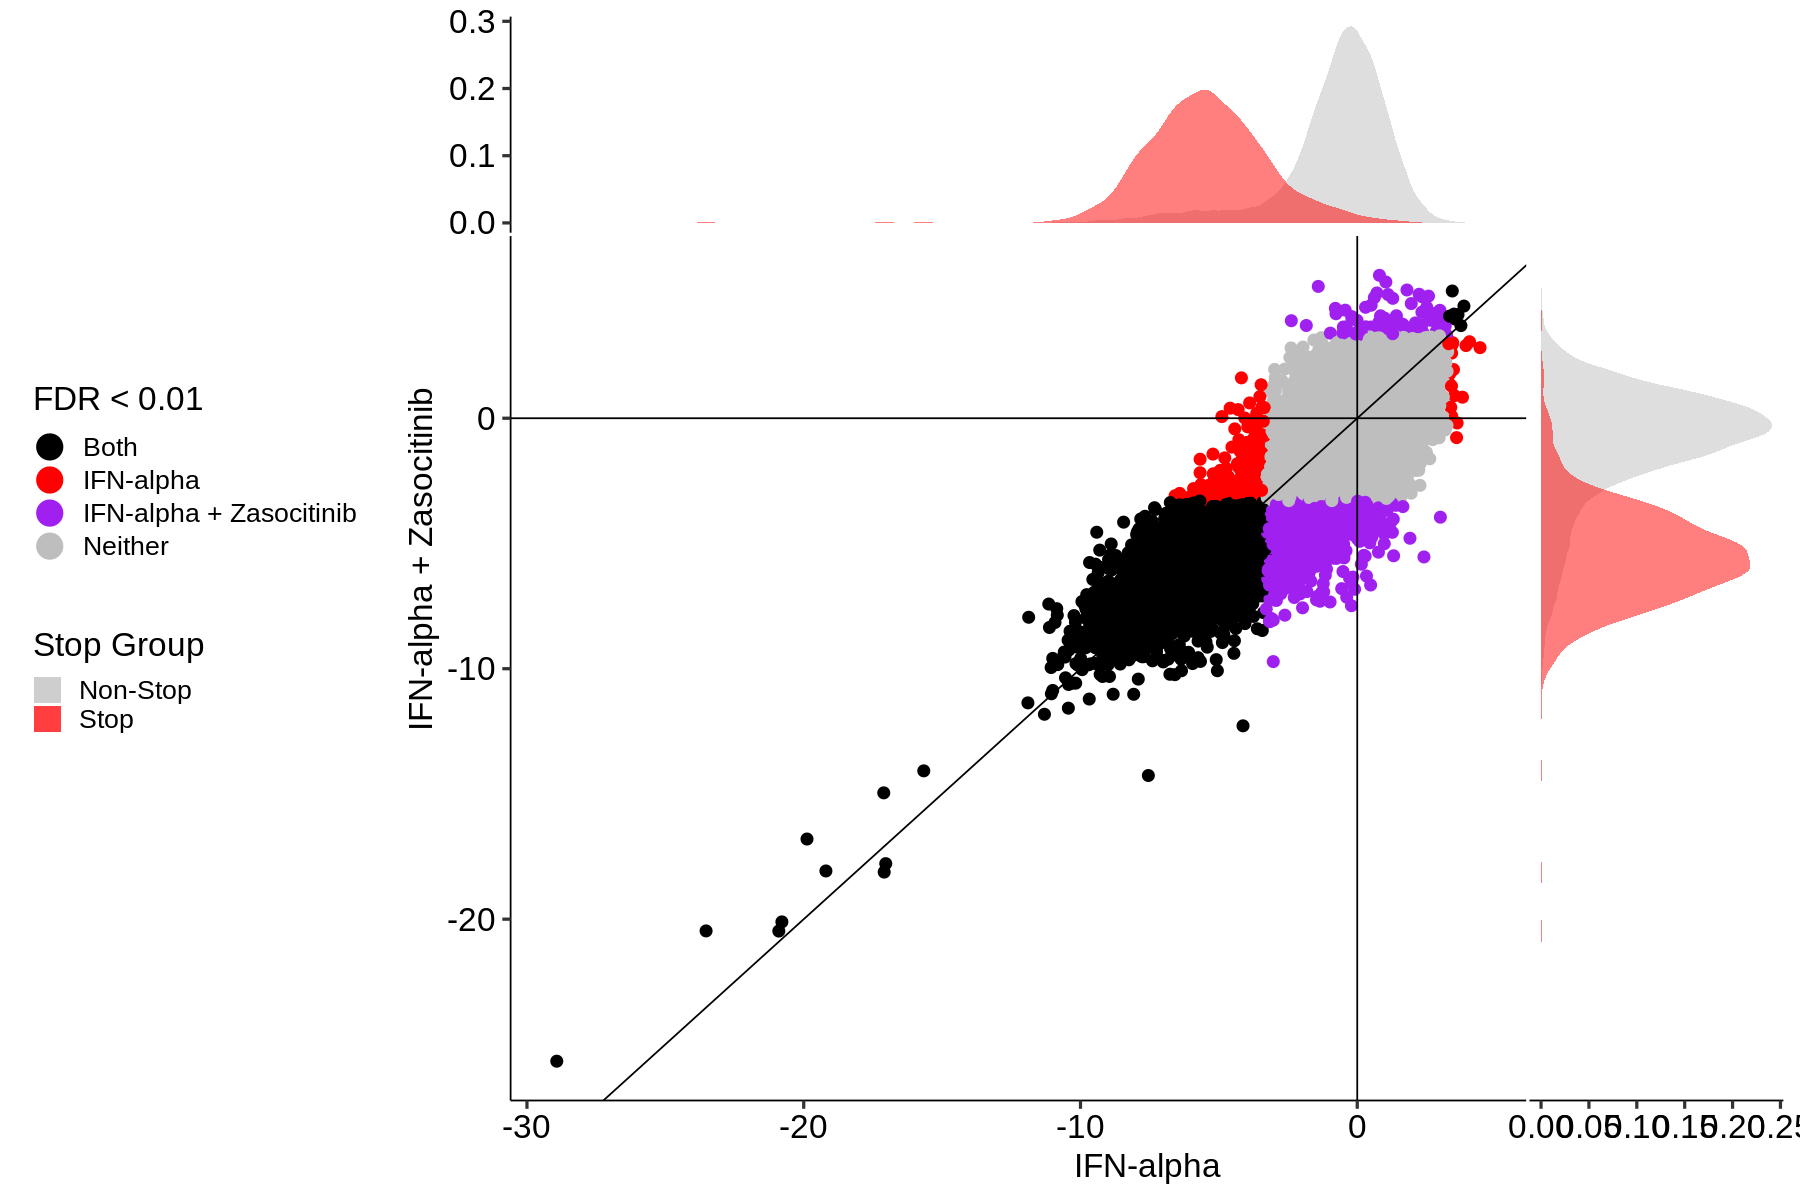

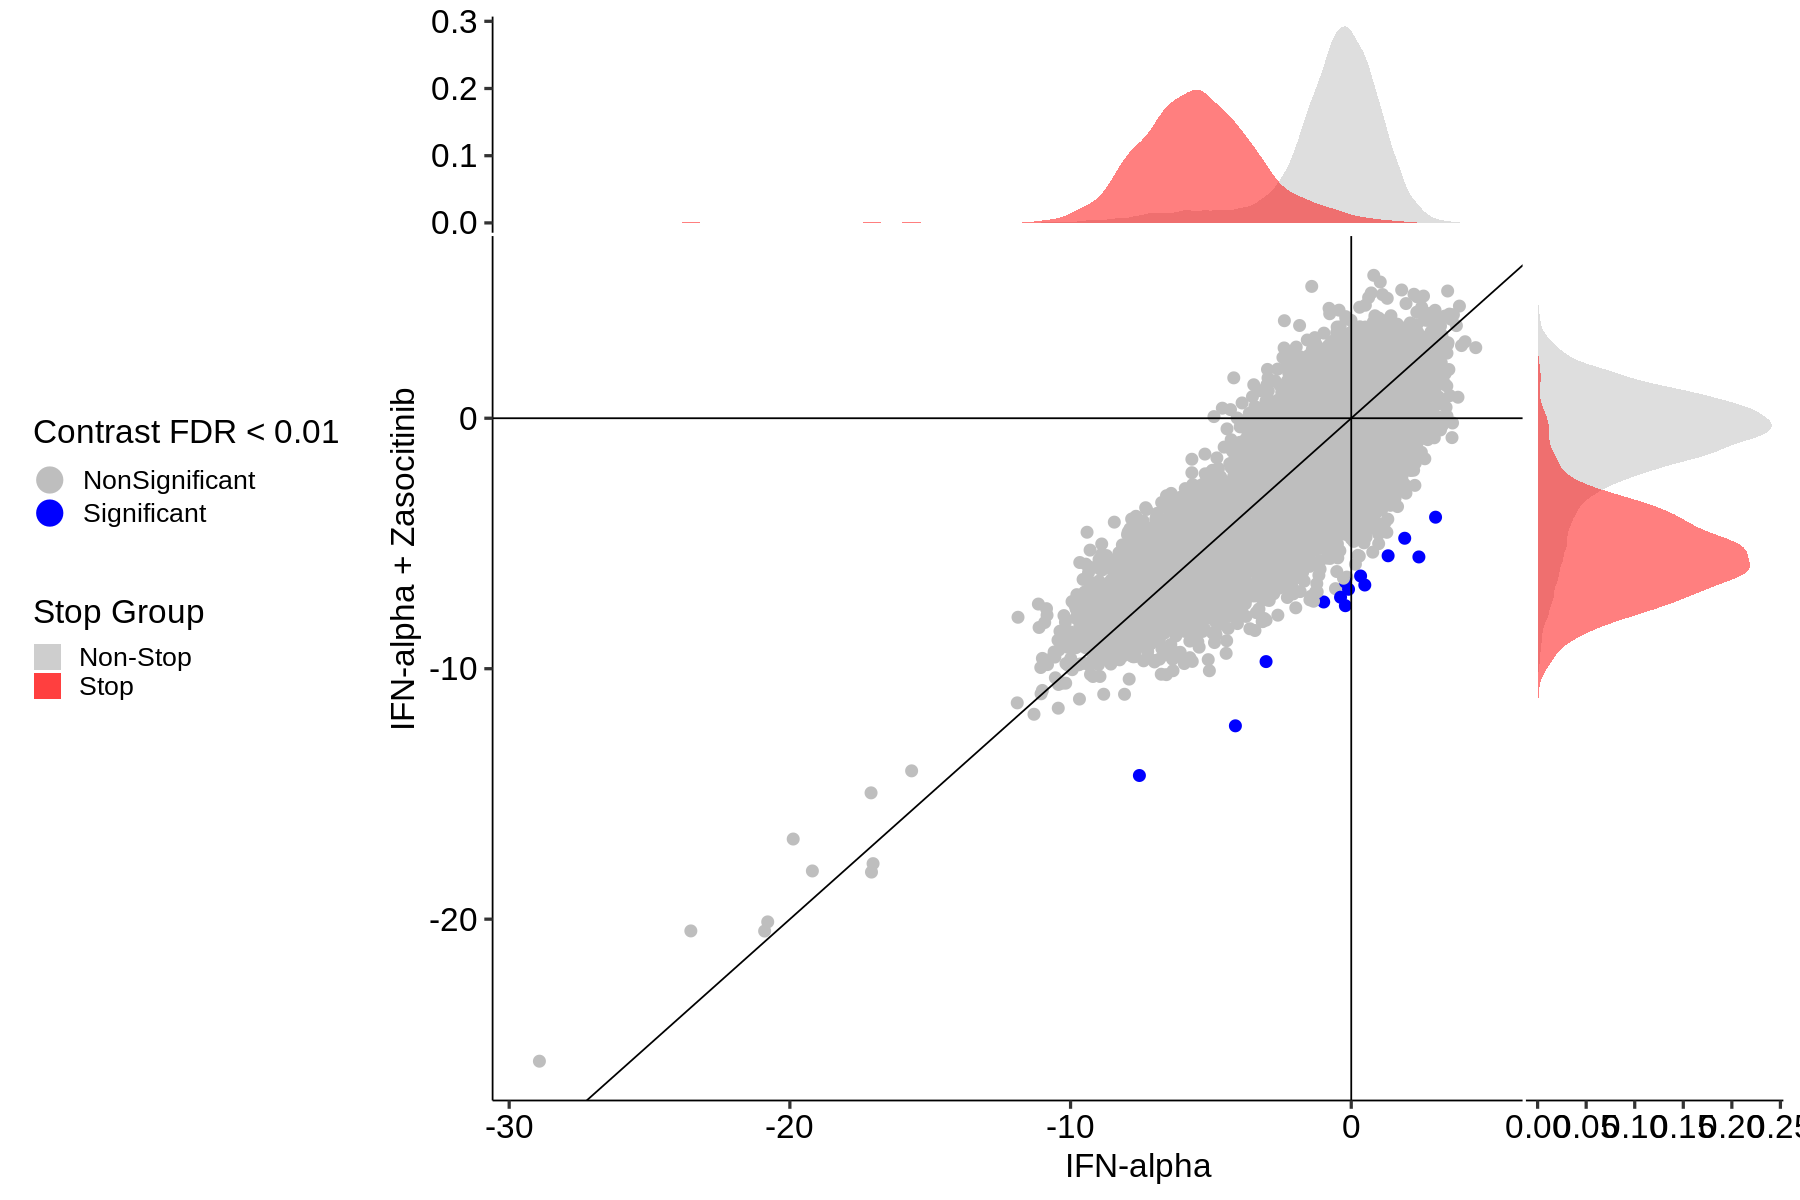

In [183]:
options(repr.plot.width = 15, repr.plot.height = 10)

zaso_siglist <- zaso_poten %>%
    filter(estimate < 0, p.adj < 0.01) %>%
    mutate(mut_id = str_c(pos, aa)) %>% pull(mut_id)

conds <- c("IFNalpha100_0", "IFNalpha100+Zasocitinib_7e-09")
labels <- c("IFN-alpha", "IFN-alpha + Zasocitinib")

colors <- c("black", "red", "purple","gray")
names(colors) <- c("Both", labels[1], labels[2], "Neither")

compare_potentiation(zaso_siglist, conds, labels, colors, "FDR < 0.01", sumstats)

contrast_colors <- c("grey", "blue")
names(contrast_colors) <- c("NonSignificant", "Significant")

compare_potentiation(zaso_siglist, conds, labels, contrast_colors, "Contrast FDR < 0.01", sumstats)

Much like for drug resistence, we can also plot them directly against each other since the IFN-alpha terms will cancel out in the final contrast:

In [26]:
colors <- c("purple", "red", "blue","black")
names(colors) <- c("Both", "BMS-986202", "Zasocitinib", "Neither")

bms_siglist <- potentiation_sumstats %>%
    filter(estimate < 0, p.adj < 0.01, drug == "IFNalpha100+BMS-986202") %>%
    mutate(mut_id = str_c(pos, aa)) %>% pull(mut_id)

zaso_siglist <- potentiation_sumstats %>%
    filter(estimate < 0, p.adj < 0.01, drug == "IFNalpha100+Zasocitinib") %>%
    mutate(mut_id = str_c(pos, aa)) %>% pull(mut_id)

potentiation_scatter_data <- potentiation_sumstats %>%
    select(drug, pos, aa, statistic, p.adj) %>%
    pivot_wider(names_from = drug, values_from = c(statistic, p.adj))  %>%
    mutate("FDR < 0.01" = case_when(`p.adj_IFNalpha100+BMS-986202` < 0.01 & `p.adj_IFNalpha100+Zasocitinib` > 0.01 ~ "BMS-986202",
                               `p.adj_IFNalpha100+BMS-986202` > 0.01 & `p.adj_IFNalpha100+Zasocitinib` < 0.01 ~ "Zasocitinib",
                               `p.adj_IFNalpha100+BMS-986202` < 0.01 & `p.adj_IFNalpha100+Zasocitinib` < 0.01 ~ "Both",
                               TRUE ~ "Neither"),
           `FDR < 0.01` = if_else(`statistic_IFNalpha100+BMS-986202` > 0,
                                 "Neither",
                                 `FDR < 0.01`))

potentiation_scatter_plot <- ggplot(potentiation_scatter_data) +
    geom_point(data = potentiation_scatter_data %>% filter(`FDR < 0.01` != "Neither"),
              aes(x = `statistic_IFNalpha100+BMS-986202`,
                  y = `statistic_IFNalpha100+Zasocitinib`,
                  #label = str_c(pos, aa),
                  color = `FDR < 0.01`), size = 5) +
    geom_point(data = potentiation_scatter_data %>% filter(`FDR < 0.01` == "Neither"),
               aes(x = `statistic_IFNalpha100+BMS-986202`,y = `statistic_IFNalpha100+Zasocitinib`,
                   color = `FDR < 0.01`)) +
    theme_pubr(base_size = 16) +
    scale_alpha_identity()  +
    scale_color_manual(values = colors) +
    xlab("Z-Statistic, [IFN-alpha + BMS-986202] - [IFN-alpha]") +
    ylab("Z-Statistic, [IFN-alpha + Zasocitinib] - [IFN-alpha]") +
    ggtitle("Assay 7 Potentiation: [IFNa + Inhibitor] Minus [IFNa]") +
    theme(legend.title = element_blank())

ggsave("../dataviz/TYK2/ifna/TYK2-IFNaDMS-Assay7-DrugPotentiateCompare-NoVarLabel.pdf",
       potentiation_scatter_plot,
       width = 10, height = 10)

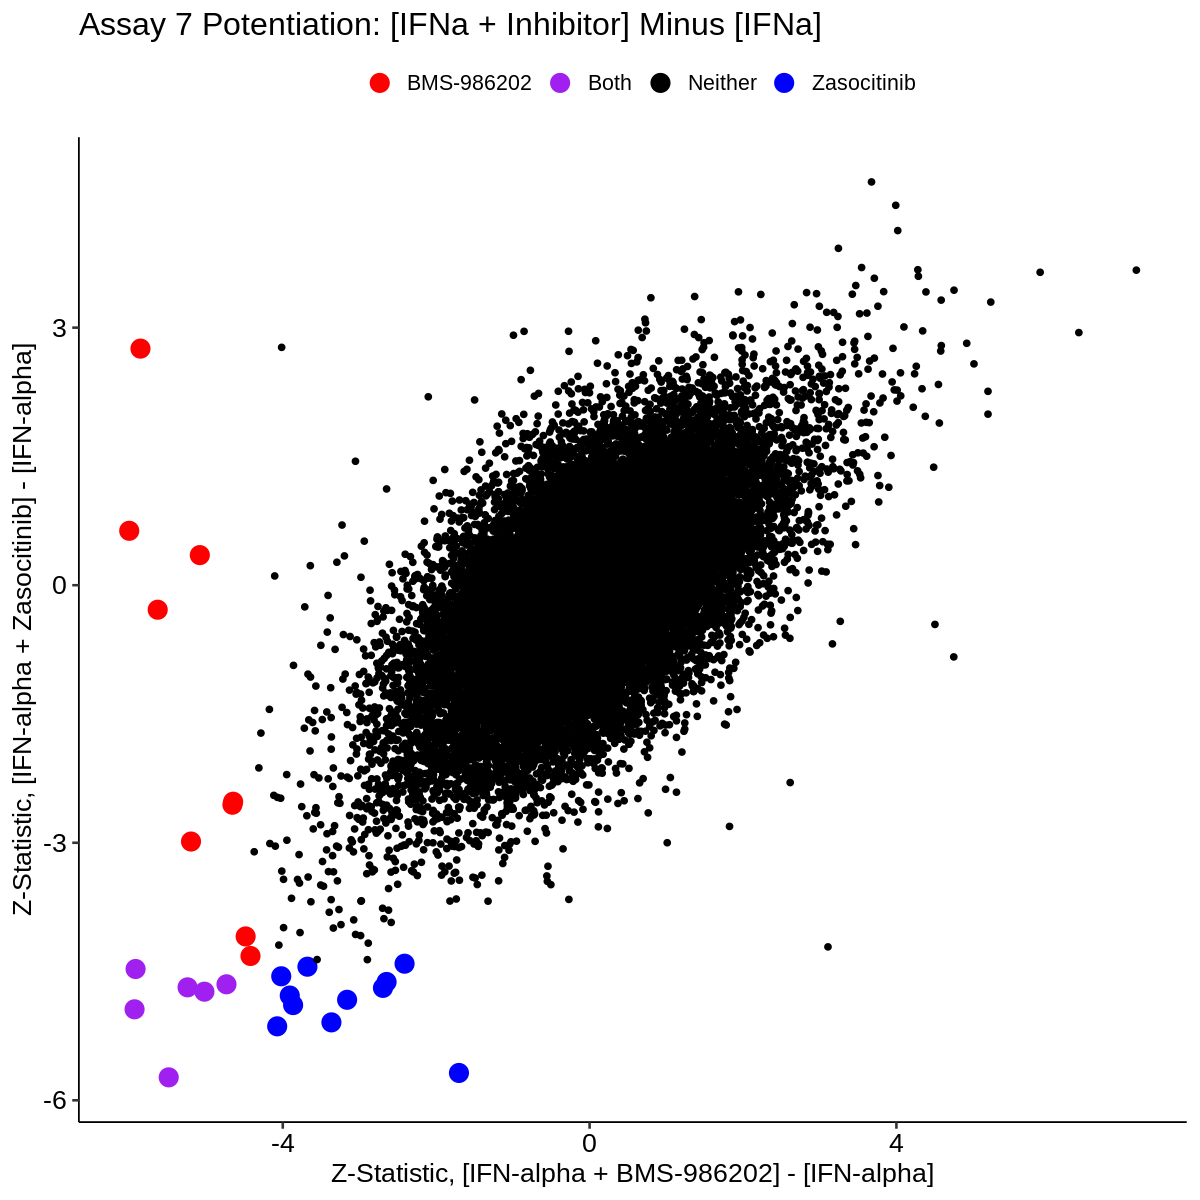

In [27]:
options(repr.plot.width = 10, repr.plot.height = 10)
potentiation_scatter_plot

In [44]:
colors <- c("Both" = "purple", "Zasocitinib" = "blue",
            "BMS-986202" = "red", "Neither" = "black")

scatter_data <- potentiation_sumstats %>%
    select(pos, drug, aa, statistic, p.adj) %>%
    pivot_wider(names_from = drug, values_from = c(statistic, p.adj)) %>%
    mutate("FDR < 0.01" = case_when(`p.adj_IFNalpha100+BMS-986202` < 0.01 & `p.adj_IFNalpha100+Zasocitinib` > 0.01 ~ "BMS-986202",
                               `p.adj_IFNalpha100+BMS-986202` > 0.01 & `p.adj_IFNalpha100+Zasocitinib` < 0.01 ~ "Zasocitinib",
                               `p.adj_IFNalpha100+BMS-986202` < 0.01 & `p.adj_IFNalpha100+Zasocitinib` < 0.01 ~ "Both",
                               TRUE ~ "Neither"),
           `FDR < 0.01` = if_else(`statistic_IFNalpha100+BMS-986202` > 0,
                                 "Neither",
                                 `FDR < 0.01`))

In [45]:
sig_pos <- scatter_data %>% filter(`FDR < 0.01` != "Neither") %>% pull(pos) %>% unique()

color_grid_all <- scatter_data %>%
    filter(pos %in% sig_pos, aa != "*") %>%
    mutate(aa = factor(aa, levels = c("N","Q","F","W","Y","L","I","V","M","D","E","C","S","T","R","H","K","P","A","G"))) %>%
    ggplot() +
        geom_tile(aes(x = as.factor(pos), y = aa, fill = `FDR < 0.01`)) +
        theme_pubr(base_size = 20) +
        xlab("Residue") + ylab("Amino Acid") +
        ggtitle("Normalized to Untreated") +
        scale_fill_manual(values = c("Both" = "purple", "Zasocitinib" = "blue",
            "BMS-986202" = "red", "Neither" = "lightgray"))

pdf("../dataviz/TYK2/ifna/TYK2-IFNaDMS-Assay7-DrugPotentiateGrid.pdf", height = 9, width = 13)
color_grid_all + scale_fill_manual(values = c("Both" = "blue", "Zasocitinib" = "blue",
            "BMS-986202" = "lightgray", "Neither" = "lightgray"))
color_grid_all + scale_fill_manual(values = c("Both" = "red", "Zasocitinib" = "lightgray",
            "BMS-986202" = "red", "Neither" = "lightgray"))
color_grid_all + scale_fill_manual(values = c("Both" = "purple", "Zasocitinib" = "blue",
            "BMS-986202" = "red", "Neither" = "lightgray"))
dev.off()

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


png 
  2

In [46]:
sig_pos <- scatter_data %>% filter(`FDR < 0.01` %in% c("Both", "BMS-986202")) %>% pull(pos) %>% unique()

color_grid_bmsonly <- scatter_data %>%
    filter(pos %in% sig_pos, aa != "*") %>%
    mutate(aa = factor(aa, levels = c("N","Q","F","W","Y","L","I","V","M","D","E","C","S","T","R","H","K","P","A","G"))) %>%
    mutate(`FDR < 0.01` = if_else(`FDR < 0.01` %in% c("Neither", "Zasocitinib"), "Non-Significant", "Significant")) %>%
    ggplot() +
        geom_tile(aes(x = as.factor(pos), y = aa, fill = `FDR < 0.01`)) +
        theme_pubr(base_size = 20) +
        xlab("Residue") + ylab("Amino Acid") +
        ggtitle("BMS-986202, Normalized to Untreated")

pdf("../dataviz/TYK2/ifna/TYK2-IFNaDMS-Assay7-DrugPotentiateGrid-BMSonly.pdf", height = 9, width = 8)
color_grid_bmsonly + scale_fill_manual(values = c("Significant" = "red", "Non-Significant" = "lightgray"))
dev.off()

png 
  2

We can pull out this list of variants specifically and profile them:

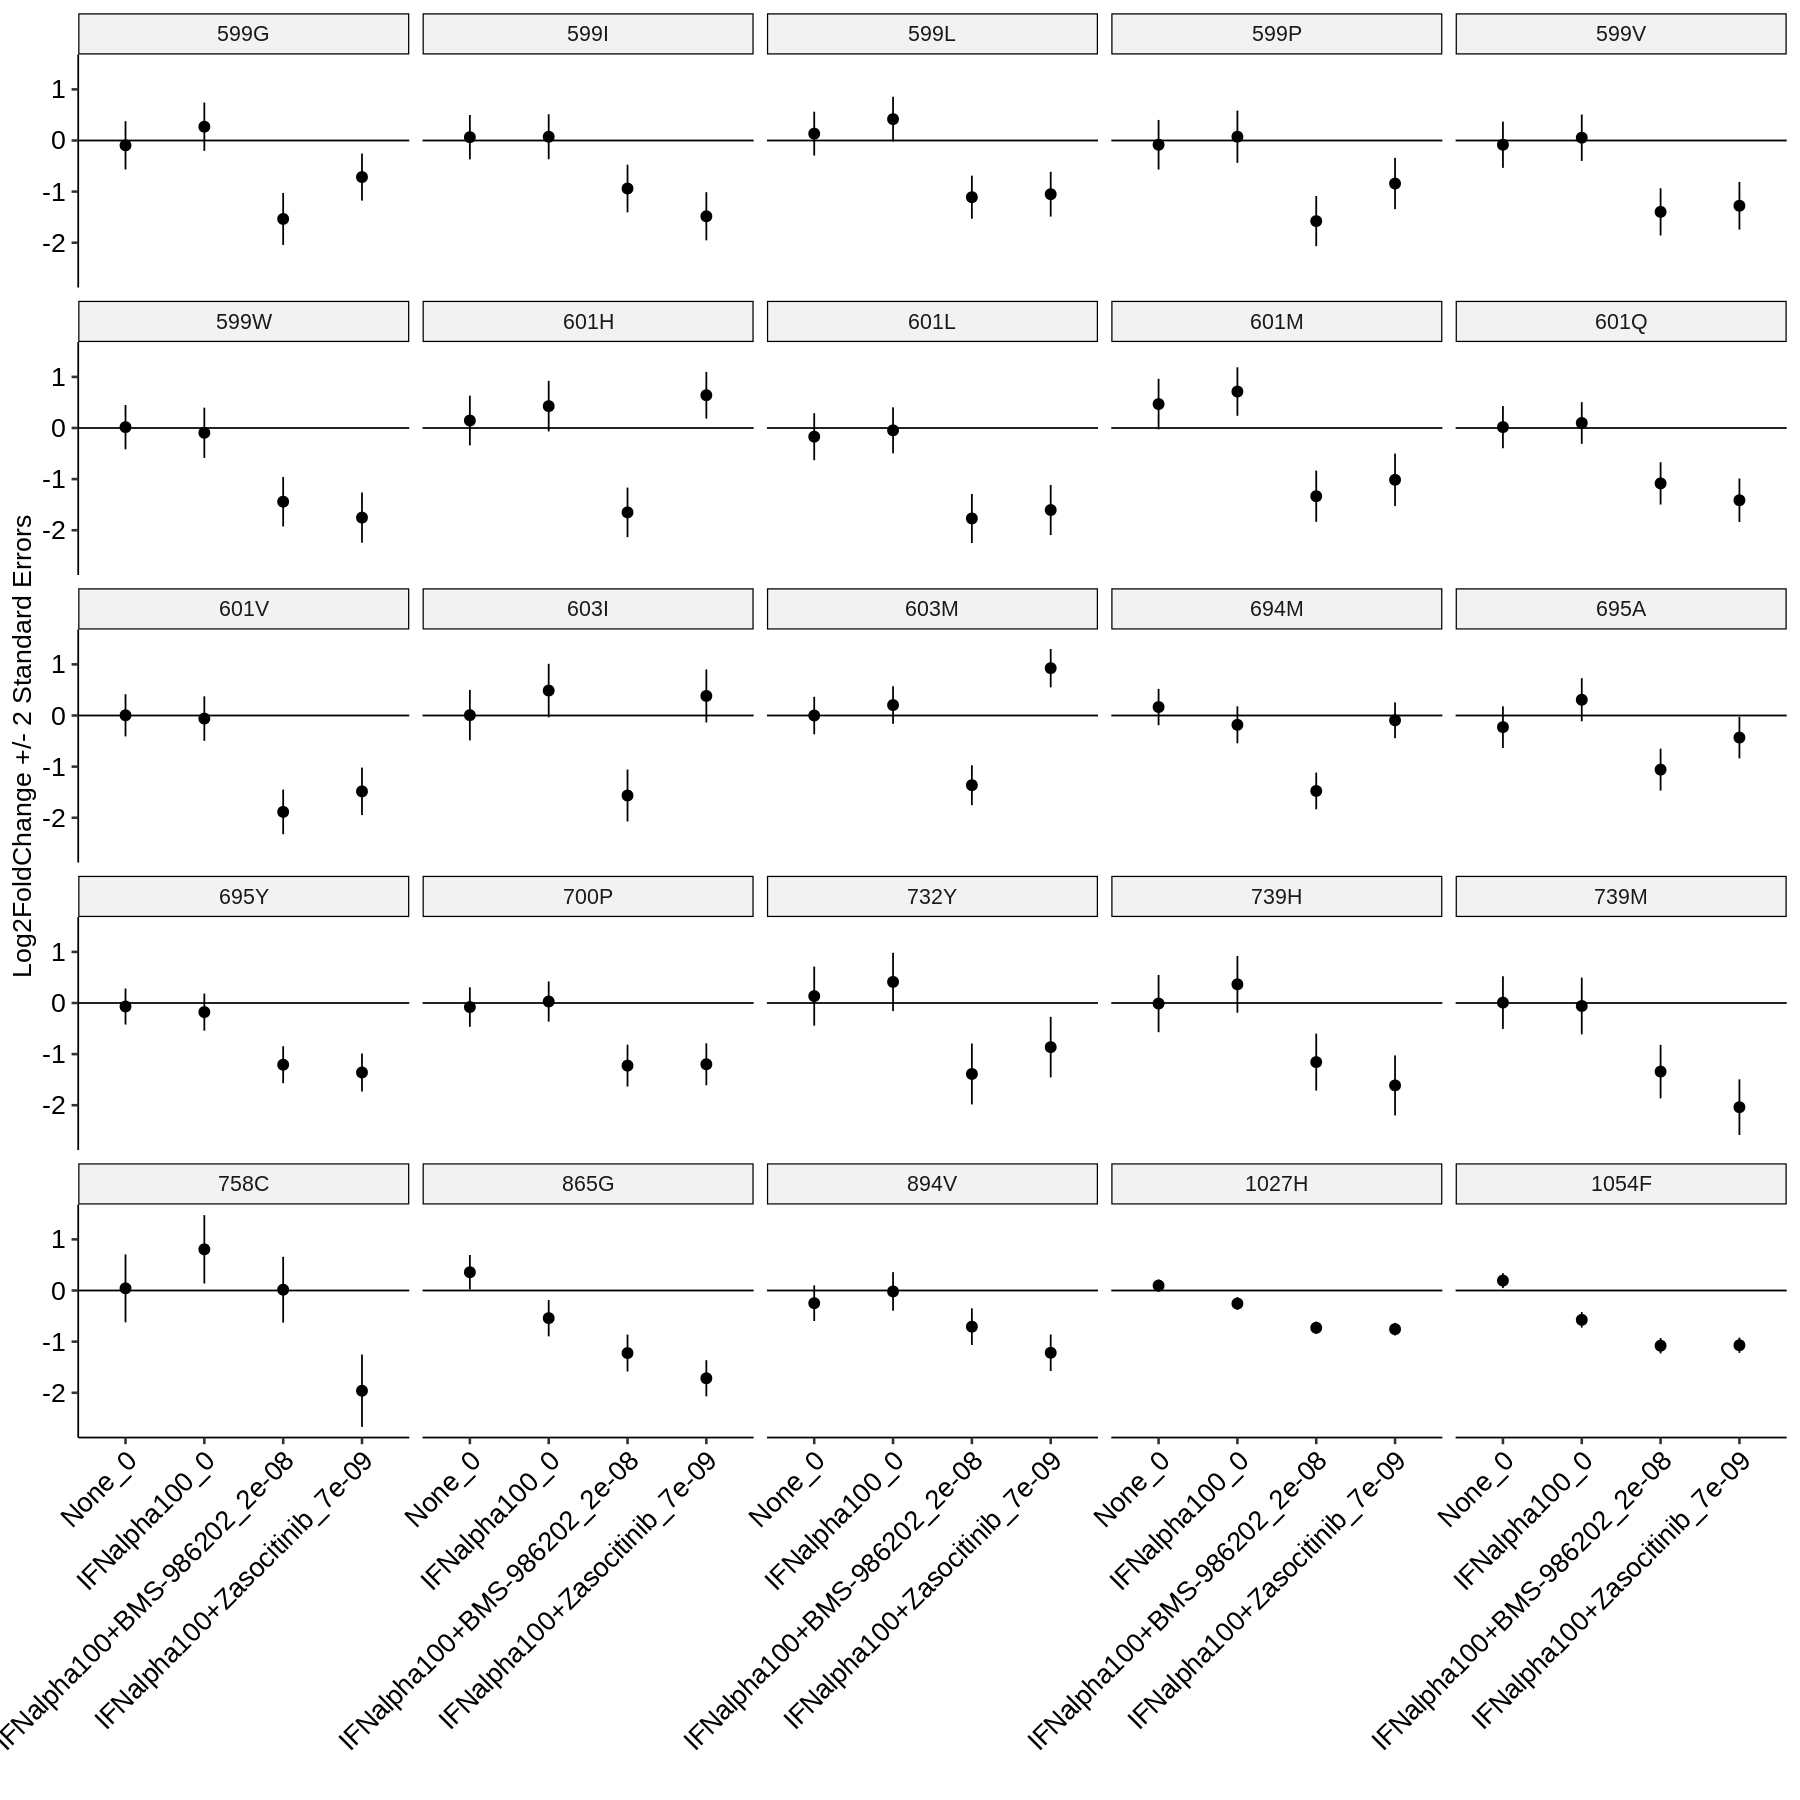

In [215]:
options(repr.plot.width = 15, repr.plot.height = 15)
sumstats %>%
    filter(condition != "IFNalpha100+Ropsacitinib_1e-05",
           str_c(pos, aa) %in% c(zaso_siglist, bms_siglist)) %>%
    mutate(condition = relevel(factor(condition), ref = "None_0")) %>%
    ggplot() +
        geom_pointrange(aes(x = condition, y = estimate,
                            ymin = estimate - 2*std.error,
                            ymax = estimate + 2*std.error)) +
        theme_pubr(base_size = 16, x.text.angle = 45) +
        geom_hline(yintercept = 0) +
        facet_wrap(~reorder(str_c(pos,aa),pos)) +
        xlab("") + ylab("Log2FoldChange +/- 2 Standard Errors")

Generally, these variants have no effect on function in None or IFNalpha, but become very negative relative to WT under one or both of the inhibitors.

In [229]:
potentiation_vars <- bind_rows(bms_poten %>% select(drug, pos, aa, estimate, p.adj),
          zaso_poten %>% select(drug, pos, aa, estimate, p.adj)) %>%
    pivot_wider(names_from = drug, values_from = c(estimate, p.adj)) %>%
    filter(str_c(pos, aa) %in% c(zaso_siglist, bms_siglist)) %>%
    arrange(pos, aa)

names(potentiation_vars) <- c("Position", "AA",
                              "Log2FoldChange, IFNalpha+BMS-986202 - IFNalpha100",
                              "Log2FoldChange, IFNalpha+BMS-986202 - IFNalpha100",
                              "FDR, IFNalpha+Zasocitinib - IFNalpha100",
                              "FDR, IFNalpha+Zasocitinib - IFNalpha100")

potentiation_vars %>%
    kable("markdown", digits = 5)



| Position|AA | Log2FoldChange, IFNalpha+BMS-986202 - IFNalpha100| Log2FoldChange, IFNalpha+BMS-986202 - IFNalpha100| FDR, IFNalpha+Zasocitinib - IFNalpha100| FDR, IFNalpha+Zasocitinib - IFNalpha100|
|--------:|:--|-------------------------------------------------:|-------------------------------------------------:|---------------------------------------:|---------------------------------------:|
|      599|G  |                                          -1.80356|                                          -0.98476|                                 0.00035|                                 0.37116|
|      599|I  |                                          -1.01279|                                          -1.55607|                                 0.15470|                                 0.00464|
|      599|L  |                                          -1.52703|                                          -1.46847|                                 0.00076|                                 0.00555

In [5]:
aggregate_cols <- function(df, method = c("average", "maximum", "average_significant")) {
    
    if(method %in% c("average", "average_significant")){
        
        if(method == "average_significant"){
            thresh <- 0.01
        }else{
            thresh <- 2
        }
        
        agg_data <-  df %>%
            ungroup() %>%
            filter(aa != "*", p.adj < thresh) %>%
            group_by(pos, clone, chunk, version, condition) %>%
            summarize(estimate = mean(estimate),
                      std.error = sqrt(sum(std.error^2)/length(unique(aa))),
                      statistic = estimate / std.error) %>%
            mutate(condition = paste0(condition, " ", "Aggregated Across Residues"))

        null_rows <- expand_grid(pos = 1:1187,
                    condition = unique(paste0(df$condition, " ", "Aggregated Across Residues")), 
                    statistic = 0) %>%
            filter(!paste0(pos, condition) %in% paste0(agg_data$pos, agg_data$condition))

        agg_data <- agg_data %>%
            ungroup() %>%
            select(pos, condition, statistic) %>% 
            bind_rows(null_rows)

        return(agg_data)
        
    } else if(method == "maximum") {
        
        agg_data <-  df %>%
            ungroup() %>%
            filter(aa != "*") %>%
            group_by(pos, clone, chunk, version, condition) %>%
            filter(statistic == sign(statistic)*max(abs(statistic))) %>%
            ungroup() %>%
            select(pos, condition, statistic)
        
        return(agg_data)
    }
}

Rows: 94876 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (6): drug, clone, chunk, aa, version, condition
dbl (8): conc, pos, estimate, std.error, dispersion, statistic, p.value, p.adj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'pos', 'clone', 'chunk', 'version'. You can
override using the `.groups` argument.


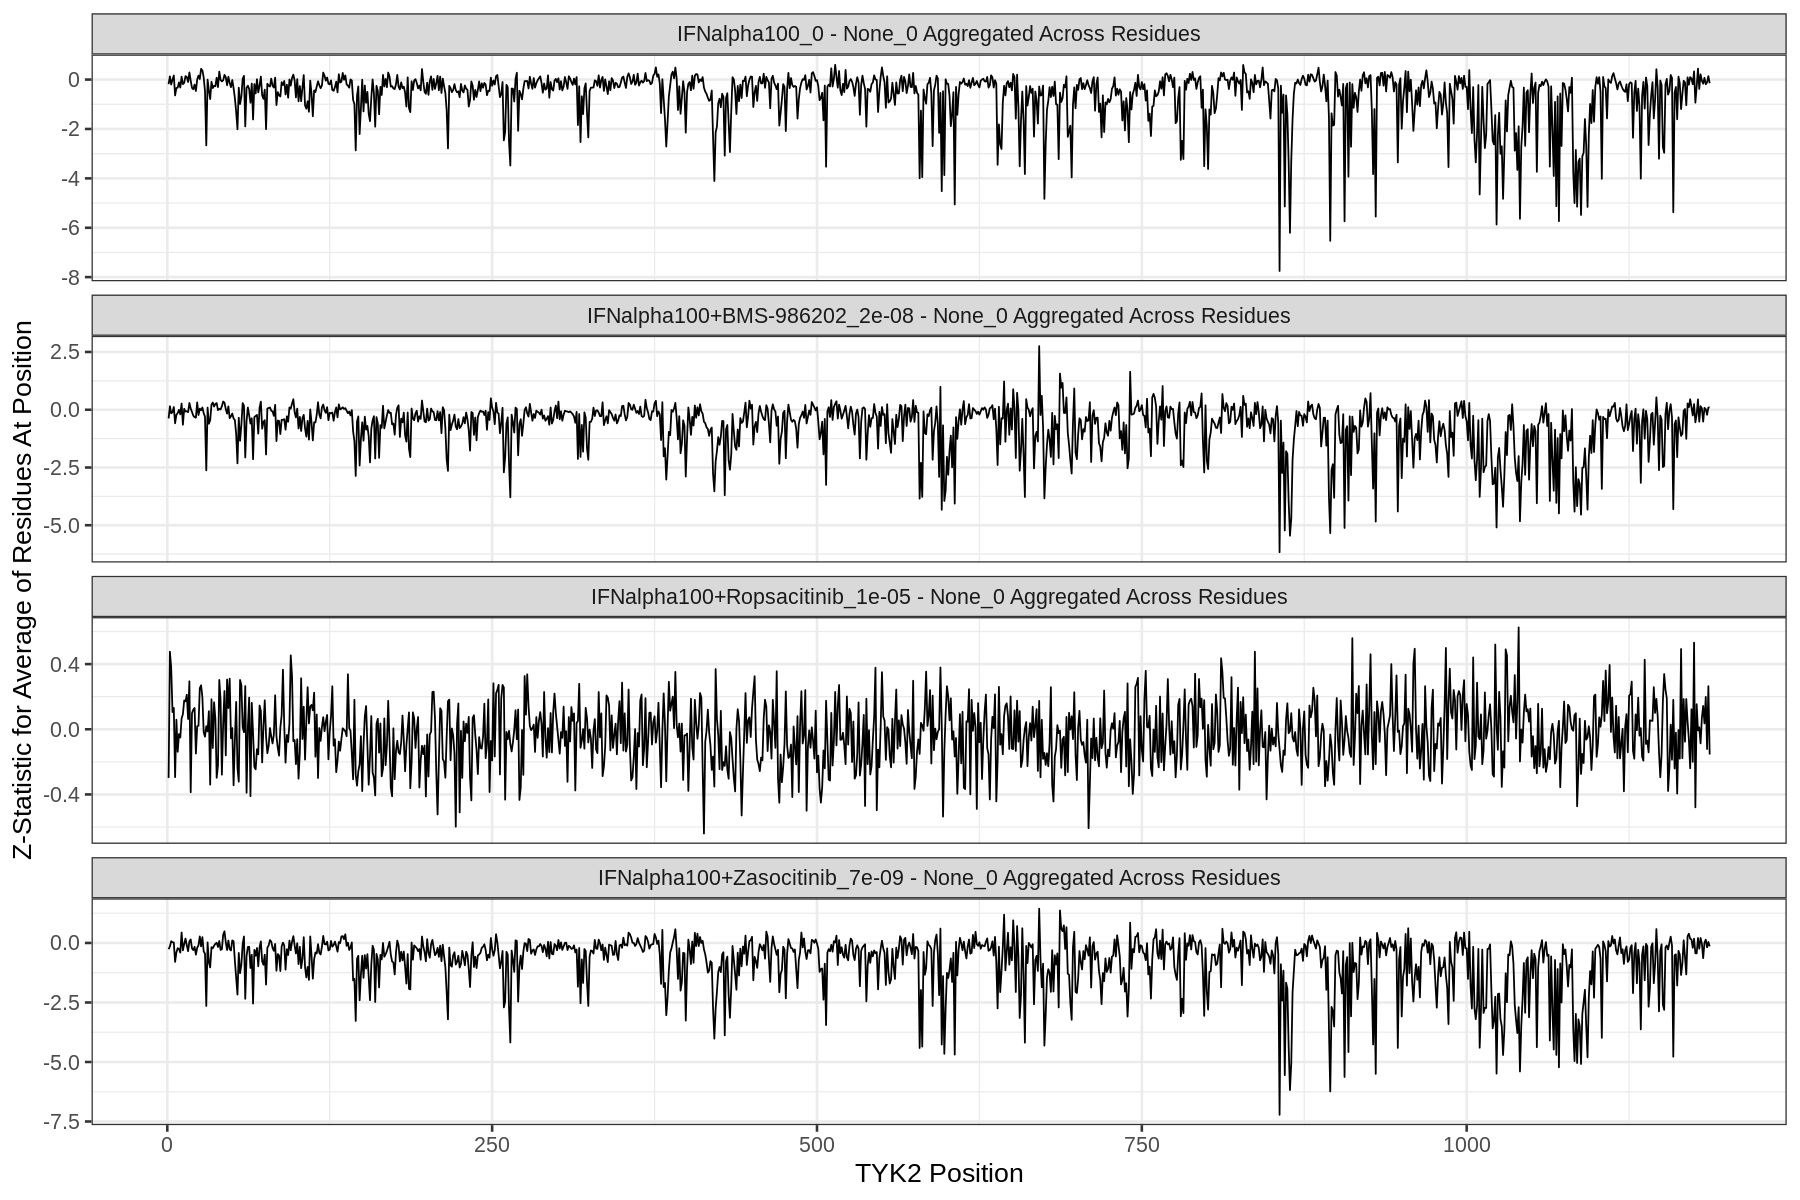

In [8]:
sumstats_all <- read_tsv("../sumstats/TYK2/run7/tyk2-assay7.tsv")

agg_data <-  aggregate_cols(sumstats_all, method = "average")

agg_plot <- ggplot(agg_data) +
            geom_line(aes(x = pos, y = statistic)) +
            theme_bw(base_size = 16) +
            facet_wrap(~condition, ncol = 1, scales = "free_y") +
            xlab("TYK2 Position") + ylab("Z-Statistic for Average of Residues At Position")

options(repr.plot.width = 15, repr.plot.height = 10)
agg_plot

In [13]:
agg_data %>%
    filter(condition == "IFNalpha100_0 - None_0 Aggregated Across Residues") %>%
    write_tsv("../dataviz/TYK2/ifna/TYK2-IFNaDMS-Assay7-AggByPos.tsv")